# Set up

In [173]:
import pandas as pd
import pingouin as pg
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn import metrics
from scipy.stats import norm

import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from util.calc_util import calc_fisher
from ast import literal_eval


In [174]:
large_font = 20
medium_font = 15
small_font = 10 

# Load Clinical Data and perform filtering + add PCs

In [175]:
integrated_df_path = "data/clin_df.tsv"
clinical_df = pd.read_csv(integrated_df_path,sep="\t")
clinical_df.head()


,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT_MGI_20200608,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT_UKB_20200608,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASSOSUM_MGI_20200608,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_PT_MGI_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_LASSOSUM_UKB_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_MGI_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_UKB_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_MGI_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_UKB_20200608
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,True,True,False,...,0.000088,-0.000060,0.000024,0.003521,7.820000e-07,5.620000e-06,-1.140000e-07,-5.560000e-08,0.000957,-0.002350
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,True,False,False,...,0.000873,0.000800,0.000030,0.004716,2.650000e-06,9.620000e-06,7.690000e-08,6.060000e-08,0.002676,0.003009
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,False,False,False,...,0.000425,0.000548,0.000014,0.001436,3.570000e-07,-9.280000e-08,-6.660000e-08,-8.940000e-08,0.001812,0.000084
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.000656,0.000868,0.000046,0.012965,1.600000e-05,2.240000e-05,5.210000e-08,5.630000e-08,0.003256,0.006383
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,False,False,True,...,0.000876,0.001066,0.000022,0.009197,4.840000e-06,1.160000e-05,-6.180000e-08,-6.680000e-08,0.004745,0.007003


## Loading coverage info on lpWGS and WES

In [176]:
lpwgs_coverage_df = pd.read_csv("data/lpWGS_sample.tsv",sep="\t")
lpwgs_coverage_df["ID"] = ["_".join(name.split("-")[:3]) for name in lpwgs_coverage_df["entity:sample_id"]]
lpwgs_coverage_df_subset = lpwgs_coverage_df[lpwgs_coverage_df["ID"].isin(clinical_df["ID"])]

clinical_df_wes = clinical_df.copy()
lpwgs_coverage_df_subset.head()


,entity:sample_id,hg38_sampleMeanCoverage,ID
0,BC-P-001-P1-B1_L_172936,1.29,BC_P_001
1,BC-P-002-P1-C1_L_172937,1.12,BC_P_002
2,BC-P-003-P1-D1_L_172938,1.18,BC_P_003
3,BC-P-004-P1-E1_L_172939,1.33,BC_P_004
4,BC-P-005-P1-F1_L_172940,1.40,BC_P_005


## Figure 2 (panel a&b)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

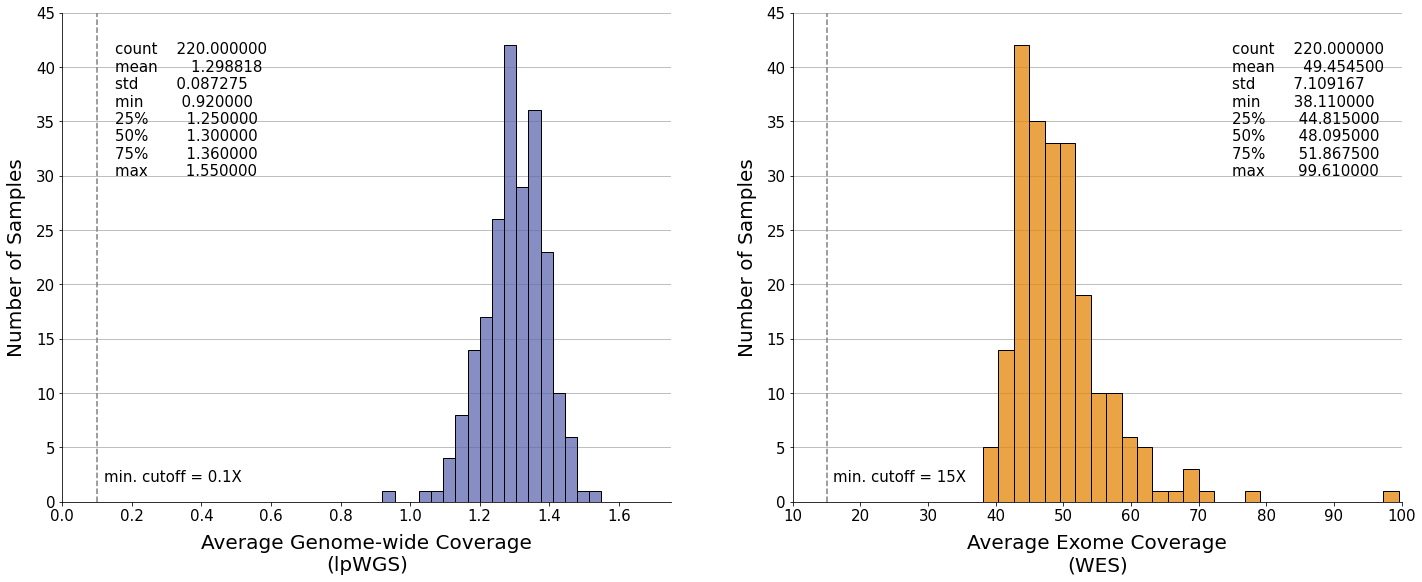

In [177]:
from palettable.colorbrewer.qualitative import Set1_5
from palettable.cartocolors.qualitative import Vivid_5

fig,axes = plt.subplots(figsize=(24,9),ncols=2)

## lpwgs
sns.histplot(data=lpwgs_coverage_df_subset,x="hg38_sampleMeanCoverage",ax=axes[0],color=Vivid_5.mpl_colors[1])
axes[0].set_axisbelow(True)
axes[0].grid(axis="y")

axes[0].spines.top.set_visible(False)
axes[0].spines.right.set_visible(False)

axes[0].tick_params(axis='both', which='major', labelsize=medium_font)
axes[0].set_xlabel("Average Genome-wide Coverage\n(lpWGS)",fontsize=large_font,labelpad=10)
axes[0].set_ylabel("Number of Samples",fontsize=large_font,labelpad=10)

axes[0].set_xlim((0,1.75))
axes[0].set_ylim((0,45))
axes[0].axvline(0.1,linestyle="--",color="gray")

display_str = "\n".join(str(lpwgs_coverage_df_subset["hg38_sampleMeanCoverage"].describe()).split("\n")[:-1])

axes[0].annotate(xy=(0.15,30),text=display_str,fontsize=medium_font)
axes[0].annotate(xy=(0.12,1.85),text="min. cutoff = 0.1X",fontsize=medium_font)

## WES
sns.histplot(data=clinical_df_wes,x="sampleMeanCoverage",ax=axes[1],color=Vivid_5.mpl_colors[0])
axes[1].set_axisbelow(True)
axes[1].grid(axis="y")

axes[1].spines.top.set_visible(False)
axes[1].spines.right.set_visible(False)

axes[1].tick_params(axis='both', which='major', labelsize=medium_font)
axes[1].set_xlabel("Average Exome Coverage\n(WES)",fontsize=large_font,labelpad=10)
axes[1].set_ylabel("Number of Samples",fontsize=large_font,labelpad=10)

axes[1].set_xlim((10,100))
axes[1].set_ylim((0,45))
axes[1].axvline(15,linestyle="--",color="gray")

display_str = "\n".join(str(clinical_df_wes["sampleMeanCoverage"].describe()).split("\n")[:-1])

axes[1].annotate(xy=(75,30),text=display_str,fontsize=medium_font)
axes[1].annotate(xy=(16,1.85),text="min. cutoff = 15X",fontsize=medium_font)

plt.savefig("figures/fig_2_coverage_plot.png",dpi=300)
plt.savefig("figures/fig_2_coverage_plot.eps",dpi=300)



## Figure 2 (Panel c&d)

In [183]:
# Add PC information
pc_df = pd.read_csv("data/ancestry_pcs.tsv",sep="\t")
scores = [literal_eval(score) for score in pc_df["scores"]]
pc_components_df = pd.DataFrame(data=scores,columns=[f"PC_{i}" for i in range(1,101)])

# Keep only first 10 PCs
pc_components_df = pc_components_df.iloc[:,:10]
pc_components_df.insert(0,"ID",pc_df["s"].apply(lambda x: "_".join(x.split("-")[:3])))
clinical_df = clinical_df.merge(pc_components_df,left_on="ID",right_on="ID",how="left")

ancestry_df = pd.read_csv("data/ancestry_assignments.tsv",sep="\t")
pc_components_df_with_ancestry = ancestry_df.merge(pc_components_df,on="ID")
pc_components_df_with_ancestry = pc_components_df_with_ancestry.replace({"Middle Eastern":"MID (This Cohort)"})
pc_components_df_with_ancestry.head()

,ID,Population_Code,Super_Population,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,BC_P_001,MID (This Cohort),MID (This Cohort),-0.017264,-0.018577,0.038931,0.014054,0.005960,-0.016127,0.006660,0.018212,-0.004800,-0.007986
1,BC_P_002,MID (This Cohort),MID (This Cohort),0.008336,-0.015309,0.046967,0.025561,0.003875,-0.007231,0.009379,0.012910,0.008274,0.003415
2,BC_P_003,MID (This Cohort),MID (This Cohort),-0.001888,-0.010207,0.042040,0.008720,0.003740,-0.015715,0.008654,0.008089,0.000078,0.006885
3,BC_P_004,MID (This Cohort),MID (This Cohort),-0.020342,-0.014841,0.029483,0.005976,0.005031,-0.009841,0.005231,0.007291,-0.001679,-0.001122
4,BC_P_005,MID (This Cohort),MID (This Cohort),-0.017141,-0.024921,0.032897,0.007751,0.003208,0.000312,0.005803,0.004934,0.000394,0.004869


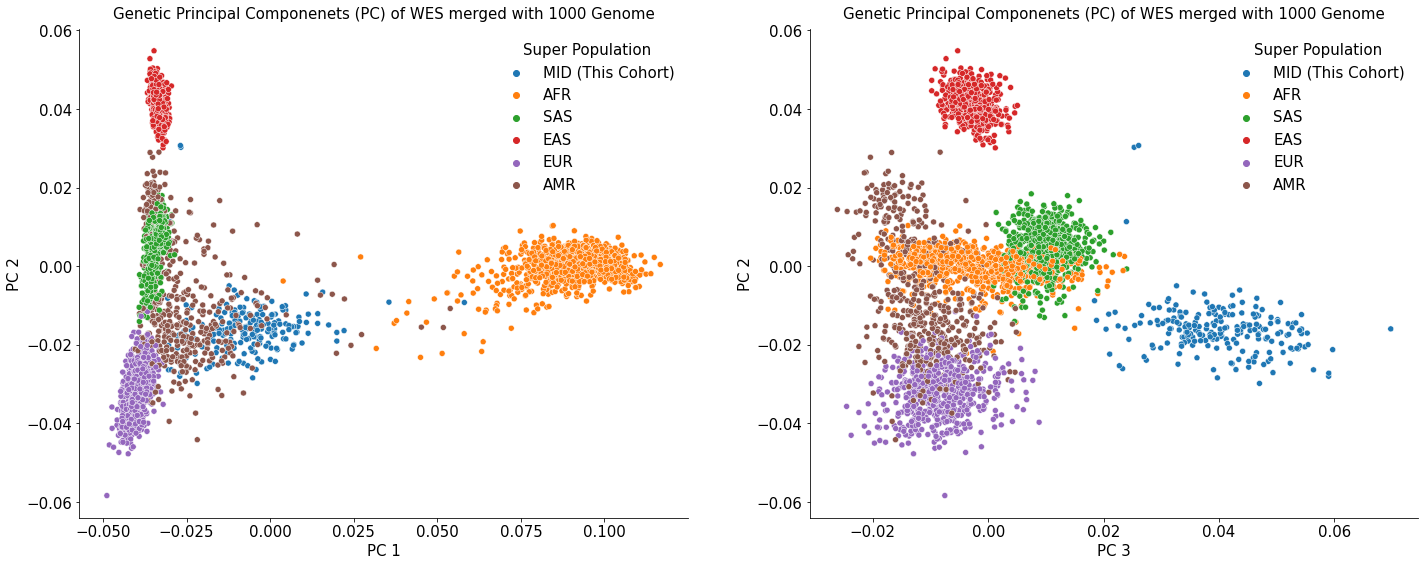

In [184]:
fig,axes = plt.subplots(figsize=(24,9),ncols=2)

sns.scatterplot(
    data=pc_components_df_with_ancestry,
    x="PC_1",
    y="PC_2",
    hue="Super_Population",
    ax=axes[0]
)

sns.despine(ax=axes[0])
sns.move_legend(axes[0],loc="upper right",frameon=False,title="Super Population",fontsize=medium_font,title_fontsize=medium_font)
axes[0].set_xlabel("PC 1",fontsize=medium_font)
axes[0].set_ylabel("PC 2",fontsize=medium_font)

sns.scatterplot(
    data=pc_components_df_with_ancestry,
    x="PC_3",
    y="PC_2",
    hue="Super_Population",
    ax=axes[1]
)

sns.despine(ax=axes[1])
sns.move_legend(axes[1],loc="upper right",frameon=False,title="Super Population",fontsize=medium_font,title_fontsize=medium_font)
axes[1].set_xlabel("PC 3",fontsize=medium_font)
axes[1].set_ylabel("PC 2",fontsize=medium_font)

axes[0].set_title("Genetic Principal Componenets (PC) of WES merged with 1000 Genome",pad=10,size=medium_font)
axes[1].set_title("Genetic Principal Componenets (PC) of WES merged with 1000 Genome",pad=10,size=medium_font)

axes[0].tick_params(axis='both', which='major', labelsize=medium_font)
axes[1].tick_params(axis='both', which='major', labelsize=medium_font)

plt.savefig("figures/fig_2_pc_plot.png",dpi=300)
plt.savefig("figures/fig_2_pc_plot.eps",dpi=300)




# Figure 3 (See Plot Exome Dosage Notebook)

# Figure 4 (PRS AUC correlation)

In [185]:
## Remove individuals with unreported family history of breast cancer or are related for downstream analysus
clinical_df_filtered = clinical_df[clinical_df['RelatednessQC_Removed']==False].copy()
clinical_df_filtered = clinical_df_filtered.dropna(subset=["AnyDegreeBC"])
clinical_df_filtered


,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,True,True,False,...,-0.017264,-0.018577,0.038931,0.014054,0.005960,-0.016127,0.006660,0.018212,-0.004800,-0.007986
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,True,False,False,...,0.008336,-0.015309,0.046967,0.025561,0.003875,-0.007231,0.009379,0.012910,0.008274,0.003415
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,False,False,False,...,-0.001888,-0.010207,0.042040,0.008720,0.003740,-0.015715,0.008654,0.008089,0.000078,0.006885
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,-0.020342,-0.014841,0.029483,0.005976,0.005031,-0.009841,0.005231,0.007291,-0.001679,-0.001122
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,False,False,True,...,-0.017141,-0.024921,0.032897,0.007751,0.003208,0.000312,0.005803,0.004934,0.000394,0.004869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,BC_P_231,51.0,12- Other,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.014213,-0.014546,0.030257,0.012824,-0.000345,-0.013187,0.001068,-0.017959,-0.000933,-0.001419
211,BC_P_232,61.0,1-Ductal carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,-0.003673,-0.023556,0.048962,0.019513,0.009512,-0.018513,0.006244,-0.003848,-0.008508,-0.006222
212,BC_P_233,49.0,3-Invasive ductal carcinoma,3-Grade 3,1-T1c,1-N1,0-M0,True,True,False,...,-0.009273,-0.024208,0.045156,0.022058,0.009347,-0.021321,0.009656,0.007706,0.004132,0.007492
215,BC_P_236,64.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,NaN,...,-0.010498,-0.015043,0.025404,0.003463,0.005411,-0.016236,0.007241,0.004703,-0.003644,-0.000023


## Panel A)

### Load PRS related information

In [186]:
ukb_prs_info = pd.read_csv("./data/CancerPRSWeb/174.1_UKB_1.txt",sep="\t")
mgi_prs_info = pd.read_csv("./data/CancerPRSWeb/174.1_MGI_1.txt",sep="\t")
combined_prs_info = pd.concat([ukb_prs_info,mgi_prs_info],ignore_index=True)
combined_prs_info.columns = [col.strip() for col in combined_prs_info.columns]
combined_prs_info_subset = combined_prs_info[['Prswebprefix','# SNPS','AUC Estimate','.Method']]
combined_prs_info_subset.head()


,Prswebprefix,# SNPS,AUC Estimate,.Method
0,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,64,0.596,P_5e-09
1,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,86,0.593,P_5e-08
2,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,93,0.595,P_5e-07
3,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,102,0.591,P_5e-06
4,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,105,0.588,P_5e-05


### Residualize every PRS


In [187]:
pc_cols = [f"PC_{i}" for i in range(1,11)]
prs_web_cols = [col for col in clinical_df_filtered.columns if "PRSWEB" in col and "residual" not in col]

for idx in range(len(prs_web_cols)):
    cur_prs_name = prs_web_cols[idx]
    X_pc_only = np.array(clinical_df_filtered[pc_cols],dtype=float)
    X_pc_only = sm.add_constant(X_pc_only)
    ols_model_res_prs = sm.OLS(clinical_df_filtered[cur_prs_name].to_numpy(), X_pc_only).fit(maxiter=100).resid

    clinical_df_filtered[f"{cur_prs_name}_residual"] = ols_model_res_prs
clinical_df_filtered

,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT_MGI_20200608_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT_UKB_20200608_residual,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASSOSUM_MGI_20200608_residual,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_PT_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_LASSOSUM_UKB_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_UKB_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_UKB_20200608_residual
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,True,True,False,...,-0.000383,-0.000637,1.780512e-06,0.000432,-4.503915e-06,-0.000004,-8.827125e-08,-6.180875e-08,-0.001643,-0.006295
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,True,False,False,...,0.000353,0.000201,5.432198e-06,0.001688,-1.407762e-06,0.000003,9.906111e-08,5.310167e-08,0.000664,0.002214
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,False,False,False,...,-0.000126,-0.000144,-1.140225e-05,-0.001813,-5.989668e-06,-0.000010,-6.093287e-08,-1.241809e-07,-0.000575,-0.001447
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.000163,0.000276,2.310522e-05,0.010370,9.401068e-06,0.000012,7.003773e-08,3.662484e-08,0.000183,0.003230
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,False,False,True,...,0.000327,0.000427,5.054057e-07,0.006259,-1.616811e-06,0.000002,-4.103003e-08,-8.876075e-08,0.001396,0.004129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,BC_P_231,51.0,12- Other,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.000111,0.000578,7.915601e-06,0.007955,3.100254e-06,0.000006,4.051051e-09,-4.419472e-08,0.001983,0.003564
211,BC_P_232,61.0,1-Ductal carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,-0.000157,0.000047,-9.326828e-06,-0.000192,5.687179e-06,0.000008,1.696987e-08,1.402040e-08,0.001512,0.000774
212,BC_P_233,49.0,3-Invasive ductal carcinoma,3-Grade 3,1-T1c,1-N1,0-M0,True,True,False,...,-0.000076,0.000030,-1.360022e-05,-0.002124,-4.663860e-06,-0.000005,-1.156117e-08,-2.673160e-09,0.000003,-0.002358
215,BC_P_236,64.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,NaN,...,0.000032,0.000233,-8.013520e-06,-0.002969,7.507120e-07,0.000003,-5.687064e-09,2.747332e-08,0.001612,0.003057


### Get performance of each set of PRS (alone + residualized against top 10 PCs)

In [188]:
pc_cols = [f"PC_{i}" for i in range(1,11)]

df_to_eval = clinical_df_filtered[clinical_df_filtered["FirstDegreeBC"].notna()]

prs_web_cols = [col for col in clinical_df_filtered.columns if "PRSWEB" in col and "residual" not in col]
prs_web_first_bc_aurocs = [roc_auc_score(df_to_eval["FirstDegreeBC"]==True, df_to_eval[col]) for col in prs_web_cols]
prs_web_any_bc_aurocs = [roc_auc_score(df_to_eval["AnyDegreeBC"]==True, df_to_eval[col]) for col in prs_web_cols]

residualzed_prs = {}

rows = []

for idx in range(len(prs_web_cols)):
    cur_prs_name = prs_web_cols[idx]
    
    y1 = np.array(df_to_eval["FirstDegreeBC"],dtype=float)
    y2 = np.array(df_to_eval["AnyDegreeBC"],dtype=float)
    y3 = np.array(df_to_eval[cur_prs_name],dtype=float)

    gaussian_model_res_prs = df_to_eval[f"{cur_prs_name}_residual"]

    auroc_first_prs_only = roc_auc_score(y1==True, df_to_eval[cur_prs_name])
    auroc_first_prs_res_only = roc_auc_score(y1==True, gaussian_model_res_prs)
    
    auroc_any_prs_only = roc_auc_score(y2==True, df_to_eval[cur_prs_name])
    auroc_any_prs_res_only = roc_auc_score(y2==True, gaussian_model_res_prs)
    
    rows.append([
        cur_prs_name,auroc_first_prs_only,auroc_first_prs_res_only,
        auroc_any_prs_only,auroc_any_prs_res_only,
    ])
    

prs_web_fam_df = pd.DataFrame(data=rows,columns=[
    'prs_name','prs_first_fam_auroc_prs_only',"prs_resid_first_fam_auroc",
    'prs_any_fam_auroc_prs_only',"prs_resid_any_fam_auroc"
])
prs_web_fam_df.loc[prs_web_fam_df["prs_name"].str.contains("_MGI"),"DB"] = "MGI"
prs_web_fam_df.loc[prs_web_fam_df["DB"].isna(),"DB"] = "UKB"

prs_web_fam_df_merged = prs_web_fam_df.merge(combined_prs_info_subset,left_on="prs_name",right_on="Prswebprefix",how="left").sort_values(by="prs_resid_any_fam_auroc",ascending=False).reset_index(drop=True)
prs_web_fam_df_merged






,prs_name,prs_first_fam_auroc_prs_only,prs_resid_first_fam_auroc,prs_any_fam_auroc_prs_only,prs_resid_any_fam_auroc,DB,Prswebprefix,# SNPS,AUC Estimate,.Method
0,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,0.649371,0.662629,0.596072,0.604800,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,118388,0.639,Lassosum
1,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,0.655771,0.661943,0.587088,0.586831,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,286144,0.643,Lassosum
2,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,0.666171,0.656000,0.581954,0.579772,MGI,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,6977,0.611,Lassosum
3,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,0.625029,0.641829,0.551405,0.563214,UKB,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,1116546,0.623,PRS-CS
4,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,0.573486,0.572571,0.556283,0.553074,UKB,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,79,0.599,P&T
5,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,0.566857,0.579657,0.551149,0.551277,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,1682,0.631,P&T
6,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,0.558400,0.549943,0.562315,0.551020,UKB,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,105,0.588,P_5e-05
7,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,0.593029,0.601829,0.551983,0.550635,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,3038,0.635,P&T
8,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,0.569600,0.575771,0.540752,0.545630,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,1119140,0.647,PRS-CS
9,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,0.591086,0.603200,0.541843,0.544859,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,1120410,0.652,PRS-CS


In [189]:
prs_web_fam_df_merged.to_csv("./data/outputs/prs_performances.tsv",sep="\t",index=False)


###  Plotting

In [190]:
prs_web_fam_df_merged = pd.read_csv("./data/outputs/prs_performances.tsv",sep="\t")
prs_web_fam_df_merged = prs_web_fam_df_merged.rename(columns={".Method":"Method"})
prs_web_fam_df_merged = prs_web_fam_df_merged.replace({"P_5e-05":r"GWAS Catalog ($p<5\times10^{-5}$)"})


In [191]:
def joint_plot_with_pval(df,col_x,col_y):
    graph = sns.jointplot(data=df,x=col_x, y=col_y, kind="reg")
    x = df[col_x].to_numpy()
    y = df[col_y].to_numpy()
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    r, p = stats.spearmanr(x[~nas],y[~nas])
    # if you choose to write your own legend, then you should adjust the properties then
    phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
    # here graph is not a ax but a joint grid, so we access the axis through ax_joint method
    graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

<ipython-input-192-fed5aaf32c65>:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_4_prs_auc_correlations.png",dpi=300,bbox_layout="tight")
<ipython-input-192-fed5aaf32c65>:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_4_prs_auc_correlations.eps",dpi=300,bbox_layout="tight")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artis

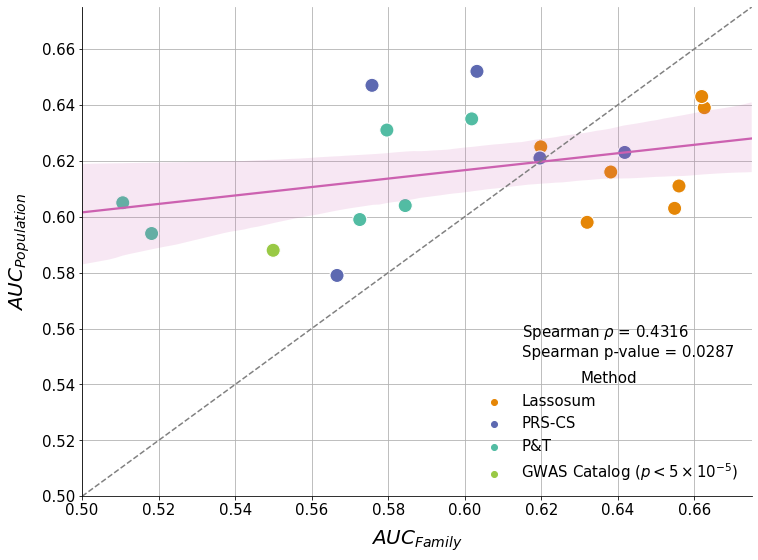

In [192]:
fig,ax = plt.subplots(figsize=(12,9))

col_x = "prs_resid_first_fam_auroc"
col_y = "AUC Estimate"

from palettable.colorbrewer.qualitative import Set1_5
from palettable.cartocolors.qualitative import Vivid_5


prs_method_color_palette = {
    "Lassosum": Vivid_5.mpl_colors[0],
    "PRS-CS": Vivid_5.mpl_colors[1],
    "P&T": Vivid_5.mpl_colors[2],
    r"GWAS Catalog ($p<5\times10^{-5}$)": Vivid_5.mpl_colors[3],
}


sns.scatterplot(
    data=prs_web_fam_df_merged,
    x=col_x,
    y=col_y,
    hue="Method",
    ax=ax,
    s=200,
    palette=prs_method_color_palette
)

ax.set_axisbelow(True)
ax.set_xlim((0.5,0.675))
ax.set_ylim((0.5,0.675))


sns.regplot(
    data=prs_web_fam_df_merged,
    x=col_x,
    y=col_y,
    marker='',
    line_kws={"color":Vivid_5.mpl_colors[4]},
    ax=ax,
    truncate=False
)

ax.plot([0, 1], [0, 1], transform=ax.transAxes,linestyle="--",color="gray")

sns.move_legend(ax,"lower right",frameon=False,fontsize=medium_font,title_fontsize=medium_font)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("$AUC_{Family}$",size=large_font,labelpad=10)
ax.set_ylabel("$AUC_{Population}$",size=large_font,labelpad=10)
ax.grid(axis="x")
ax.grid(axis="y")

ax.tick_params(axis='both', which='major', labelsize=medium_font)


x = prs_web_fam_df_merged[col_x].to_numpy()
y = prs_web_fam_df_merged[col_y].to_numpy()
nas = np.logical_or(np.isnan(x), np.isnan(y))
r, p = stats.spearmanr(x[~nas],y[~nas],alternative="greater")


ax.annotate(r"Spearman p-value = "+ f"{round(p,4)}",(0.615,0.55),size=medium_font)
ax.annotate(r"Spearman $\rho$ = "+ f"{round(r,4)}",(0.615,0.557),size=medium_font)


plt.savefig("figures/fig_4_prs_auc_correlations.png",dpi=300,bbox_layout="tight")
plt.savefig("figures/fig_4_prs_auc_correlations.eps",dpi=300,bbox_layout="tight")



### Select the most performant PRS

In [193]:
#prs_to_use = prs_web_fam_df_merged.sort_values(by="prs_resid_any_fam_auroc",ascending=False)["prs_name"][0]
prs_to_use = prs_web_fam_df_merged.sort_values(by="prs_resid_first_fam_auroc",ascending=False)["prs_name"][0]
prs_to_use


'PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608'

In [194]:
prs_to_use_raw = f"{prs_to_use}_raw"
prs_to_use_raw_std = f"{prs_to_use}_raw_standardized"
prs_to_use_adjusted = f"{prs_to_use}_residual"
prs_to_use_adjusted_std = f"{prs_to_use}_residual_standardized"

def standardize_prs(df,col):
    return (df[col] - df[col].mean())/df[col].std()

clinical_df_filtered[prs_to_use_raw] = clinical_df_filtered[prs_to_use]
clinical_df_filtered[prs_to_use_raw_std] = standardize_prs(clinical_df_filtered,prs_to_use_raw)
clinical_df_filtered[prs_to_use_adjusted] = clinical_df_filtered[prs_to_use_adjusted]
clinical_df_filtered[prs_to_use_adjusted_std] = standardize_prs(clinical_df_filtered,prs_to_use_adjusted)
clinical_df_filtered

,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_PT_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_LASSOSUM_UKB_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_UKB_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_UKB_20200608_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual_standardized
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,True,True,False,...,0.000432,-4.503915e-06,-0.000004,-8.827125e-08,-6.180875e-08,-0.001643,-0.006295,4.800000e-07,-1.071499,-0.777759
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,True,False,False,...,0.001688,-1.407762e-06,0.000003,9.906111e-08,5.310167e-08,0.000664,0.002214,2.840000e-06,0.421336,0.442861
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,False,False,False,...,-0.001813,-5.989668e-06,-0.000010,-6.093287e-08,-1.241809e-07,-0.000575,-0.001447,8.440000e-07,-0.841249,-1.190310
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.010370,9.401068e-06,0.000012,7.003773e-08,3.662484e-08,0.000183,0.003230,3.680000e-06,0.952684,1.092739
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,False,False,True,...,0.006259,-1.616811e-06,0.000002,-4.103003e-08,-8.876075e-08,0.001396,0.004129,1.960000e-06,-0.135315,-0.137074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,BC_P_231,51.0,12- Other,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.007955,3.100254e-06,0.000006,4.051051e-09,-4.419472e-08,0.001983,0.003564,3.580000e-06,0.889428,0.180187
211,BC_P_232,61.0,1-Ductal carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,-0.000192,5.687179e-06,0.000008,1.696987e-08,1.402040e-08,0.001512,0.000774,3.040000e-06,0.547847,0.395077
212,BC_P_233,49.0,3-Invasive ductal carcinoma,3-Grade 3,1-T1c,1-N1,0-M0,True,True,False,...,-0.002124,-4.663860e-06,-0.000005,-1.156117e-08,-2.673160e-09,0.000003,-0.002358,1.530000e-06,-0.407314,-0.353830
215,BC_P_236,64.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,NaN,...,-0.002969,7.507120e-07,0.000003,-5.687064e-09,2.747332e-08,0.001612,0.003057,1.280000e-06,-0.565454,-0.875538


## Panel C)

In [195]:
def calc_auc_conf(auc,num_case,num_control,ci=0.95):
    alpha = 1-ci
    z_score = norm.ppf(1-(alpha/2))
    q_0 = auc*(1-auc)
    q_1 = (auc/(2-auc))-auc**2
    q_2 = ((2*(auc**2))/(1+auc)) - auc**2
    std_err = np.sqrt((q_0+(num_case-1)*q_1+(num_control-1)*q_2)/(num_case*num_control))
    upper = auc+z_score*std_err
    lower = auc-z_score*std_err
    return auc,lower,upper


def plot_multi_roc(
    df,
    labels_to_plot,
    pred_col,
    add_trivial=True,
    label_names=None,
    truth_labels=None,
    return_ranking=False,
    adjust_cols=None,
    legend_bbox=(0.55, 0.35),
    figsize=(12,9),
    label_colors=[],
    linewidth=2
):
    fig, ax = plt.subplots(figsize=figsize)
    for idx,label in enumerate(labels_to_plot):
        notna_df = df[df[label].notna()].copy()
        if truth_labels:
            truth = (notna_df[label] == truth_labels[idx]).astype(int).to_numpy()
        else:
            truth = notna_df[label].astype(int).to_numpy()
        num_case = np.sum(truth)
        num_control = len(notna_df)-num_case

        
        if adjust_cols:
            all_pred_cols = adjust_cols + [pred_col] if pred_col else adjust_cols
            X_adjusted = np.array(notna_df[all_pred_cols],dtype=float)
            X_adjusted = sm.add_constant(X_adjusted)
            y1 = truth
            
            X_adjusted_model = sm.GLM(y1, X_adjusted).fit(maxiter=100,family=sm.families.Binomial())
            pred = X_adjusted_model.predict(X_adjusted)   
        else:
            pred = notna_df[pred_col].to_numpy()

        fpr, tpr, thresh = metrics.roc_curve(truth, pred)
        auc = metrics.roc_auc_score(truth, pred)
        _,auc_lower,auc_upper = calc_auc_conf(auc,num_case,num_control)

        if label_names:
            label = label_names[idx]
        ax.plot(fpr,tpr,label=f"{label} (n={num_case}/{len(notna_df)}),\nAUC={auc:.3f} (95% CI: {auc_lower:.3f}-{auc_upper:.3f})",color=label_colors[idx],linewidth=linewidth)
    if add_trivial:
        ax.plot([0,1],[0,1],label=f"Trivial, AUC=0.5",linestyle="dashed",color="gray",linewidth=linewidth)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis="x")
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    ax.legend(bbox_to_anchor=legend_bbox, ncol=1,frameon=False)
    
    return ax
    


In [196]:
from palettable.colorbrewer.qualitative import Paired_8
from palettable.colorbrewer.qualitative import Paired_10



labels_to_plot = [
    "FirstDegreeBC",
    "AnyDegreeBC",
    "FamilyCancer_FirstDegree",
    "FamilyCancer_AnyDegree",
]
truth_labels = [
    True,
    True,
    True,
    True,
]
label_names = [
    "BC in 1st-degree relative",
    "BC in any-degree relative",
    "Any Cancer in 1st-degree relative",
    "Any Cancer in any-degree relative",
]

label_colors = [
    Paired_10.mpl_colors[9],
    Paired_10.mpl_colors[8],
    Paired_10.mpl_colors[5],
    Paired_10.mpl_colors[4]
]
fam_hist_label_palette = {
    "BC in 1st-degree relative":"#e31b1b",
    "BC in any-degree relative":"#fc9a98",
    "Any Cancer in 1st-degree relative":"#ff7f00",
    "Any Cancer in any-degree relative":"#febe6e"
}


<ipython-input-221-5c617338a3ff>:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_4_prs_tasks_auc.png",dpi=300,bbox_layout="tight")
<ipython-input-221-5c617338a3ff>:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_4_prs_tasks_auc.eps",dpi=300,bbox_layout="tight")


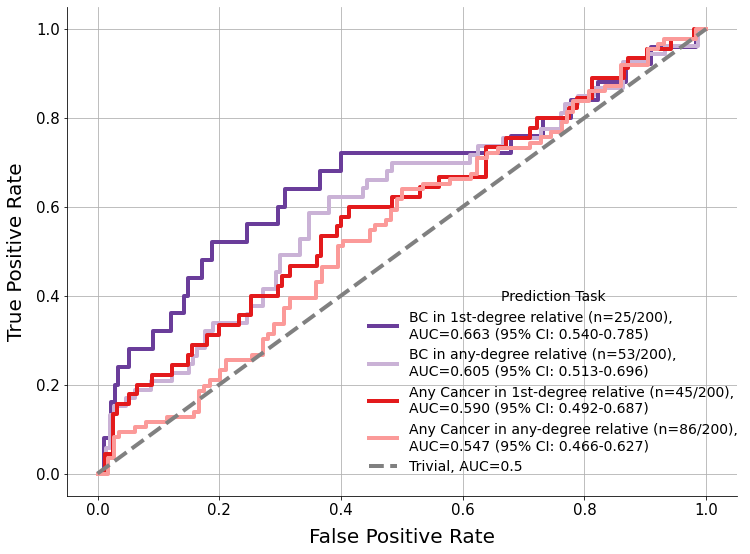

In [221]:
pred_col = prs_to_use_adjusted

ax = plot_multi_roc(
    #clinical_df_filtered[clinical_df_filtered["Age"].notna()],
    clinical_df_filtered,
    labels_to_plot,
    pred_col,
    label_names=label_names,
    truth_labels=truth_labels,
#     legend_bbox=(0.6, 0.3),
    label_colors=label_colors,
    linewidth=4
)


ax.tick_params(axis='both', which='major', labelsize=medium_font)

sns.move_legend(ax,loc="lower right",bbox_to_anchor=(1.02, 0.02),frameon=False,title="Prediction Task",fontsize=14,title_fontsize=14)

ax.set_xlabel("False Positive Rate",size=large_font,labelpad=10)
ax.set_ylabel("True Positive Rate",size=large_font,labelpad=10)
# ax.set_title("PRS Performance in Predicting Family Cancer History",size=large_font,pad=10)

plt.savefig("figures/fig_4_prs_tasks_auc.png",dpi=300,bbox_layout="tight")
plt.savefig("figures/fig_4_prs_tasks_auc.eps",dpi=300,bbox_layout="tight")





## Panel B)

In [198]:
prs_adjusted_delta_any_fam = prs_web_fam_df_merged["prs_resid_any_fam_auroc"] - prs_web_fam_df_merged["prs_any_fam_auroc_prs_only"]
prs_adjusted_delta_first_fam = prs_web_fam_df_merged["prs_resid_first_fam_auroc"] - prs_web_fam_df_merged["prs_first_fam_auroc_prs_only"]

prs_web_fam_df_merged["prs_adjusted_delta_any_fam"] = prs_adjusted_delta_any_fam
prs_web_fam_df_merged["prs_adjusted_delta_first_fam"] = prs_adjusted_delta_first_fam
prs_web_fam_df_merged



,prs_name,prs_first_fam_auroc_prs_only,prs_resid_first_fam_auroc,prs_any_fam_auroc_prs_only,prs_resid_any_fam_auroc,DB,Prswebprefix,# SNPS,AUC Estimate,Method,prs_adjusted_delta_any_fam,prs_adjusted_delta_first_fam
0,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,0.649371,0.662629,0.596072,0.604800,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,118388,0.639,Lassosum,0.008728,1.325714e-02
1,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,0.655771,0.661943,0.587088,0.586831,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,286144,0.643,Lassosum,-0.000257,6.171429e-03
2,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,0.666171,0.656000,0.581954,0.579772,MGI,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,6977,0.611,Lassosum,-0.002182,-1.017143e-02
3,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,0.625029,0.641829,0.551405,0.563214,UKB,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,1116546,0.623,PRS-CS,0.011808,1.680000e-02
4,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,0.573486,0.572571,0.556283,0.553074,UKB,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,79,0.599,P&T,-0.003209,-9.142857e-04
5,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,0.566857,0.579657,0.551149,0.551277,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,1682,0.631,P&T,0.000128,1.280000e-02
6,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,0.558400,0.549943,0.562315,0.551020,UKB,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,105,0.588,GWAS Catalog ($p<5\times10^{-5}$),-0.011295,-8.457143e-03
7,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,0.593029,0.601829,0.551983,0.550635,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,3038,0.635,P&T,-0.001348,8.800000e-03
8,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,0.569600,0.575771,0.540752,0.545630,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,1119140,0.647,PRS-CS,0.004877,6.171429e-03
9,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,0.591086,0.603200,0.541843,0.544859,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,1120410,0.652,PRS-CS,0.003016,1.211429e-02


<ipython-input-200-beaac6bee15b>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_4_prs_auc_delta.png",dpi=300,bbox_layout="tight")
<ipython-input-200-beaac6bee15b>:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_4_prs_auc_delta.eps",dpi=300,bbox_layout="tight")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be ren

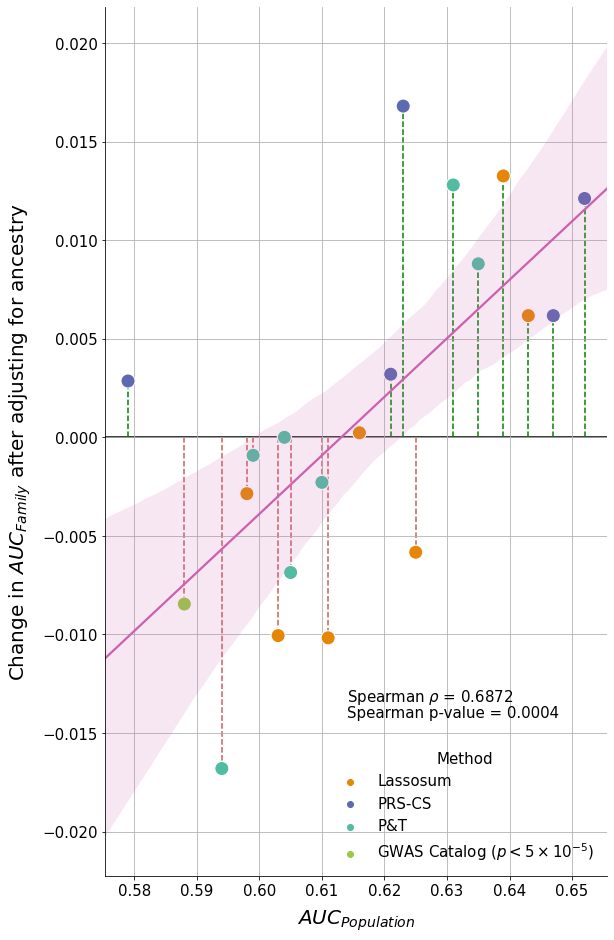

In [200]:
fig,ax = plt.subplots(figsize=(9,16))

col_x = "AUC Estimate"
col_y = "prs_adjusted_delta_first_fam"

ax.axhline(y=0,color="black",zorder=-16)
ax.set_axisbelow(True)


sns.scatterplot(
    data=prs_web_fam_df_merged,
    x=col_x,
    y=col_y,
    hue="Method",
    ax=ax,
    s=200,
    palette=prs_method_color_palette
)

for idx,row in prs_web_fam_df_merged.iterrows():
    x_coord = row[col_x]
    y_coord = row[col_y]
    color = "green" if y_coord > 0 else "indianred"
    ax.plot([x_coord,x_coord],[0,y_coord],linestyle="--",color=color,zorder=-15)

ax.set_axisbelow(True)
sns.regplot(
    data=prs_web_fam_df_merged,
    x=col_x,
    y=col_y,
    marker='',
    line_kws={"color":Vivid_5.mpl_colors[4]},
    ax=ax,
    truncate=False,
)


sns.move_legend(ax,"lower right",frameon=False,fontsize=medium_font,title_fontsize=medium_font)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("$AUC_{Population}$",size=large_font,labelpad=10)
ax.set_ylabel("Change in $AUC_{Family}$ after adjusting for ancestry",size=large_font,labelpad=10)


ax.grid(axis="x")
ax.grid(axis="y")


ax.tick_params(axis='both', which='major', labelsize=medium_font)

x = prs_web_fam_df_merged[col_x].to_numpy()
y = prs_web_fam_df_merged[col_y].to_numpy()
nas = np.logical_or(np.isnan(x), np.isnan(y))
r, p = stats.spearmanr(x[~nas],y[~nas],alternative="greater")


ax.annotate(r"Spearman p-value = "+ f"{round(p,4)}",(0.614,-0.0142),size=medium_font)
ax.annotate(r"Spearman $\rho$ = "+ f"{round(r,4)}",(0.614,-0.0134),size=medium_font)

plt.savefig("figures/fig_4_prs_auc_delta.png",dpi=300,bbox_layout="tight")
plt.savefig("figures/fig_4_prs_auc_delta.eps",dpi=300,bbox_layout="tight")



# Figure 5 (PRS Distributiin between PV and Non-PV)

## Panel A)

In [201]:
clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"] == True) & (clinical_df_filtered["Patho_Short_Variant_Carrier"] == True),
    "fam_patho_group"
] = "First Degree BC, PV Carrier"

clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"] == True) & (clinical_df_filtered["Patho_Short_Variant_Carrier"] == False),
    "fam_patho_group"
] = "First Degree BC, No PV"

clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"] == False) & (clinical_df_filtered["Patho_Short_Variant_Carrier"] == True),
    "fam_patho_group"
] = "No First Degree BC, PV Carrier"

clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"] == False) & (clinical_df_filtered["Patho_Short_Variant_Carrier"] == False),
    "fam_patho_group"
] = "No First Degree BC, No PV"

clinical_df_filtered.groupby("fam_patho_group")["Age",prs_to_use_adjusted_std].describe()



<ipython-input-201-a288d852a8b0>:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  clinical_df_filtered.groupby("fam_patho_group")["Age",prs_to_use_adjusted_std].describe()


Age                                          \
                                count       mean        std   min   25%   50%   
fam_patho_group                                                                 
First Degree BC, No PV           18.0  49.000000   8.898116  32.0  46.0  51.0   
First Degree BC, PV Carrier       7.0  45.714286  11.586116  24.0  41.0  50.0   
No First Degree BC, No PV       148.0  48.750000  10.395495  25.0  41.0  49.0   
No First Degree BC, PV Carrier   27.0  42.629630   6.697578  31.0  37.0  44.0   

                                            \
                                 75%   max   
fam_patho_group                              
First Degree BC, No PV          56.0  60.0   
First Degree BC, PV Carrier     52.5  59.0   
No First Degree BC, No PV       56.0  73.0   
No First Degree BC, PV Carrier  47.0  57.0   

                               PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual_standardized  \
                                                                                                                 count   
fam_patho_group                                                                                                          
First Degree BC, No PV                                                       18.0                                        
First Degree BC, PV Carrier                                                   7.0                                        
No First Degree BC, No PV                                                   148.0                                        
No First Degree BC, PV Carrier                                               27.0                                        

                                                                        \
                                    mean       std       min       25%   
fam_patho_group                                                          
First Degree BC, No PV          0.903667  0.891940 -0.950330  0.409646   
First Degree BC, PV Carrier    -0.498329  1.274538 -1.971425 -1.315550   
No First Degree BC, No PV      -0.072189  0.975736 -2.450358 -0.748697   
No First Degree BC, PV Carrier -0.077548  0.841356 -1.973778 -0.783972   

                                                              
                                     50%       75%       max  
fam_patho_group                                               
First Degree BC, No PV          0.882282  1.670168  2.220738  
First Degree BC, PV Carrier    -0.873777  0.258738  1.470524  
No First Degree BC, No PV      -0.063760  0.572502  2.333184  
No First Degree BC, PV Carrier  0.061769  0.521262  1.528721

In [202]:
group_test_results = []

groups_to_test = clinical_df_filtered["fam_patho_group"].dropna().unique()

for group_1 in groups_to_test:
    for group_2 in groups_to_test:
        if group_1!=group_2:
            group_1_prs = clinical_df_filtered[clinical_df_filtered["fam_patho_group"]==group_1][prs_to_use_adjusted_std].to_numpy()
            group_2_prs = clinical_df_filtered[clinical_df_filtered["fam_patho_group"]==group_2][prs_to_use_adjusted_std].to_numpy()
            #print(group_2_prs)
            _,mwu_pval = stats.mannwhitneyu(group_1_prs,group_2_prs,nan_policy="omit")
            group_test_results.append([group_1,group_2,mwu_pval])
            
fam_hist_prs = clinical_df_filtered[clinical_df_filtered["FirstDegreeBC"]==True][prs_to_use_adjusted_std]
no_fam_hist_prs = clinical_df_filtered[clinical_df_filtered["FirstDegreeBC"]==False][prs_to_use_adjusted_std]
_,fam_mwu_pval = stats.mannwhitneyu(fam_hist_prs,no_fam_hist_prs,nan_policy="omit")
group_test_results.append(["First Degree BC","No First Degree BC",fam_mwu_pval])

group_test_df = pd.DataFrame(columns=["group_1","group_2","mwu_pval"],data=group_test_results)
group_test_df


,group_1,group_2,mwu_pval
0,"No First Degree BC, PV Carrier","First Degree BC, No PV",0.000815
1,"No First Degree BC, PV Carrier","No First Degree BC, No PV",0.952239
2,"No First Degree BC, PV Carrier","First Degree BC, PV Carrier",0.314183
3,"First Degree BC, No PV","No First Degree BC, PV Carrier",0.000815
4,"First Degree BC, No PV","No First Degree BC, No PV",0.000165
5,"First Degree BC, No PV","First Degree BC, PV Carrier",0.020533
6,"No First Degree BC, No PV","No First Degree BC, PV Carrier",0.952239
7,"No First Degree BC, No PV","First Degree BC, No PV",0.000165
8,"No First Degree BC, No PV","First Degree BC, PV Carrier",0.252416
9,"First Degree BC, PV Carrier","No First Degree BC, PV Carrier",0.314183


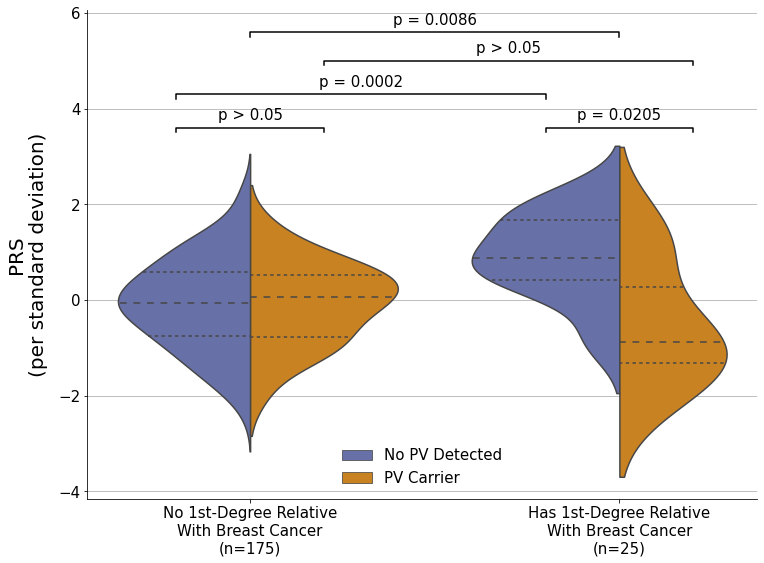

In [203]:
def add_stat_bar(ax,bar_x1,bar_x2,bar_y1,bar_y2,bar_y_top,text="ns",bar_color="black",text_offset=0.5,text_size=medium_font):
    ax.plot([bar_x1, bar_x1, bar_x2, bar_x2], [bar_y1, bar_y_top, bar_y_top, bar_y2], lw=1.5, c=bar_color)
    ax.text((bar_x1+bar_x2)*.5, bar_y_top+text_offset, text, ha='center', va='bottom', color=bar_color,size=text_size)
    return ax

clinical_df_filtered_interaction_plot = clinical_df_filtered.copy()

clinical_df_filtered_interaction_plot["Patho_Short_Variant_Carrier"] = clinical_df_filtered_interaction_plot["Patho_Short_Variant_Carrier"].replace({
    True: "PV Carrier",
    False: "No PV Detected"
})

clinical_df_filtered_interaction_plot["FirstDegreeBC"] = clinical_df_filtered_interaction_plot["FirstDegreeBC"].replace({
    True: f"Has 1st-Degree Relative\nWith Breast Cancer\n(n={clinical_df_filtered_interaction_plot['FirstDegreeBC'].sum()})",
    False: f"No 1st-Degree Relative\nWith Breast Cancer\n(n={clinical_df_filtered_interaction_plot['FirstDegreeBC'].notna().sum() - clinical_df_filtered_interaction_plot['FirstDegreeBC'].sum()})"
})

fig,ax = plt.subplots(figsize=(12,9))

hue_colors = {
    "No PV Detected":Vivid_5.mpl_colors[1],
    "PV Carrier":Vivid_5.mpl_colors[0]
}

ax.set_axisbelow(True)

sns.violinplot(
    data=clinical_df_filtered_interaction_plot,x="FirstDegreeBC",
    y=prs_to_use_adjusted_std,
    hue="Patho_Short_Variant_Carrier",
    hue_order=["No PV Detected","PV Carrier"],
    split=True,
    inner="quartile",
    ax=ax,
    zorder=3,
    palette=hue_colors
)


ax.set_axisbelow(True)
ax.grid(axis="y")

ax.set_ylabel("PRS\n(per standard deviation)",size=large_font,labelpad=10)
ax.set_xlabel("")
#ax.set_xlabel("Has First-Degree Relative With Breast Cancer",size=large_font,labelpad=10)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)


sns.move_legend(ax,title=None,loc="lower center",frameon=False,fontsize=medium_font)

pval_pv_npv_all = group_test_df[
    (group_test_df["group_1"] == "First Degree BC") & (group_test_df["group_2"] == "No First Degree BC")
]["mwu_pval"].item()
pval_pv_npv_all = f"p = {pval_pv_npv_all:.4f}" if pval_pv_npv_all < 0.05 else "p > 0.05"

pval_bc_pv_npv = group_test_df[
    (group_test_df["group_1"] == "First Degree BC, No PV") & (group_test_df["group_2"] == "First Degree BC, PV Carrier")
]["mwu_pval"].item()
pval_bc_pv_npv = f"p = {pval_bc_pv_npv:.4f}" if pval_bc_pv_npv < 0.05 else "p > 0.05"

pval_nbc_pv_npv = group_test_df[
    (group_test_df["group_1"] == "No First Degree BC, No PV") & (group_test_df["group_2"] == "No First Degree BC, PV Carrier")
]["mwu_pval"].item()
pval_nbc_pv_npv = f"p = {pval_nbc_pv_npv:.4f}" if pval_nbc_pv_npv < 0.05 else "p > 0.05"

pval_pv_bc_nbc = group_test_df[
    (group_test_df["group_1"] == "No First Degree BC, PV Carrier") & (group_test_df["group_2"] == "First Degree BC, PV Carrier")
]["mwu_pval"].item()
pval_pv_bc_nbc = f"p = {pval_pv_bc_nbc:.4f}" if pval_pv_bc_nbc < 0.05 else "p > 0.05"

pval_npv_bc_nbc = group_test_df[
    (group_test_df["group_1"] == "First Degree BC, No PV") & (group_test_df["group_2"] == "No First Degree BC, No PV")
]["mwu_pval"].item()
pval_npv_bc_nbc = f"p = {pval_npv_bc_nbc:.4f}" if pval_npv_bc_nbc < 0.05 else "p > 0.05"

add_stat_bar(ax,bar_x1=0,bar_x2=1,bar_y1=5.5,bar_y2=5.5,bar_y_top=5.6,text_offset=0.1,text=pval_pv_npv_all)

add_stat_bar(ax,bar_x1=-0.2,bar_x2=0.2,bar_y1=3.5,bar_y2=3.5,bar_y_top=3.6,text_offset=0.1,text=pval_nbc_pv_npv)
add_stat_bar(ax,bar_x1=1-0.2,bar_x2=1+0.2,bar_y1=3.5,bar_y2=3.5,bar_y_top=3.6,text_offset=0.1,text=pval_bc_pv_npv)

add_stat_bar(ax,bar_x1=-0.2,bar_x2=1-0.2,bar_y1=4.2,bar_y2=4.2,bar_y_top=4.3,text_offset=0.1,text=pval_npv_bc_nbc)
add_stat_bar(ax,bar_x1=0.2,bar_x2=1+0.2,bar_y1=4.9,bar_y2=4.9,bar_y_top=5.,text_offset=0.1,text=pval_pv_bc_nbc)


ax.tick_params(axis='both', which='major', labelsize=medium_font)

plt.savefig("figures/fig_5_rare_common_interaction.png",dpi=300)
plt.savefig("figures/fig_5_rare_common_interaction.eps",dpi=300)




## Panel B)  (Age and PRS Correlation)

### Check the exact effect of PRS on age of onset among people with first degree BC and no pathogenic variants


In [204]:

clinical_df_filtered_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==True)
    &(clinical_df_filtered["Patho_Short_Variant_Carrier"]==False)
].copy()

clinical_df_filtered_subset = clinical_df_filtered_subset[clinical_df_filtered_subset["Age"].notna()]

X = clinical_df_filtered_subset[prs_to_use_adjusted_std]
y = clinical_df_filtered_subset["Age"]

X2 = sm.add_constant(X)

gaussian_model = sm.GLM(y, X2,family=sm.families.Gaussian())
gaussian_results = gaussian_model.fit()

print(gaussian_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    Age   No. Observations:                   18
Model:                            GLM   Df Residuals:                       16
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          66.864
Method:                          IRLS   Log-Likelihood:                -62.305
Date:                Fri, 16 Dec 2022   Deviance:                       1069.8
Time:                        16:00:05   Pearson chi2:                 1.07e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2103
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

### Check if PRS is predictive of age 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

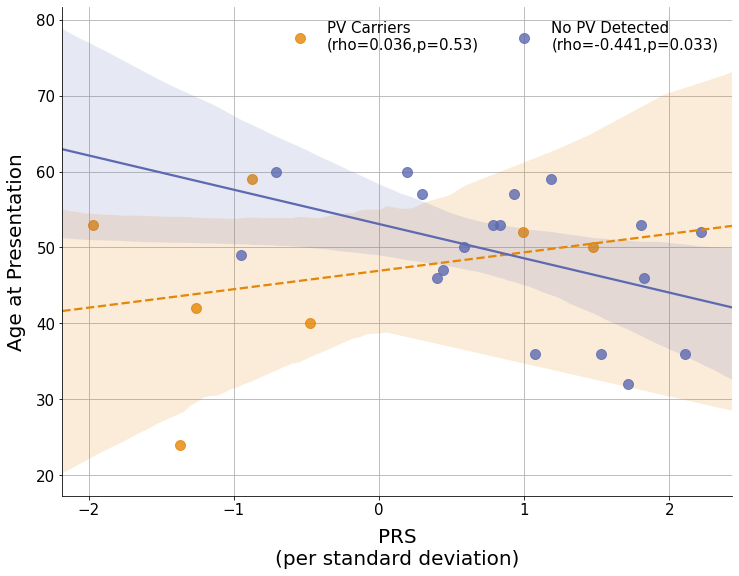

In [205]:
from palettable.cartocolors.diverging import Tropic_7
from palettable.cartocolors.qualitative import Prism_7


hue_colors = {
    False:Vivid_5.mpl_colors[1],
    True:Vivid_5.mpl_colors[0]
}


fig,ax = plt.subplots(figsize=(12,9))

fam_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==True)
].copy()

fam_patho_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==True)&
    (clinical_df_filtered["Patho_Short_Variant_Carrier"]==True)
].copy()

fam_no_patho_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==True)&
    (clinical_df_filtered["Patho_Short_Variant_Carrier"]==False)
].copy()


patho_r,patho_p = stats.spearmanr(
    fam_patho_subset[prs_to_use_adjusted_std].to_numpy(),
    fam_patho_subset["Age"].to_numpy(),
    alternative="less"
)

no_patho_r,no_patho_p = stats.spearmanr(
    fam_no_patho_subset[prs_to_use_adjusted_std].to_numpy(),
    fam_no_patho_subset["Age"].to_numpy(),
    alternative="less"
)

sns.scatterplot(data=fam_subset,x=prs_to_use_adjusted_std,y="Age",ax=ax,marker='')

ax1 = sns.regplot(
    data=fam_patho_subset,
    x=prs_to_use_adjusted_std,
    y="Age",
    truncate=False,
    ax=ax,
    color=hue_colors[True],
    #color="gray",
    label="PV Carriers\n(rho="+f"{round(patho_r,3)},p={round(patho_p,3)})",
    line_kws={"linestyle":"--"},
    scatter_kws={'s':100}
)

# ax1.legend(frameon=False,loc="upper left")

ax2 = sns.regplot(
    data=fam_no_patho_subset,
    x=prs_to_use_adjusted_std,
    y="Age",
    truncate=False,
    ax=ax,
    color=hue_colors[False],
    label=f"No PV Detected\n(rho={round(no_patho_r,3)},p={round(no_patho_p,3)})",
    scatter_kws={'s':100}
)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=medium_font)

ax.grid(axis="y")
ax.grid(axis="x")

ax.set_xlabel("PRS\n(per standard deviation)",size=large_font,labelpad=10)
ax.set_ylabel("Age at Presentation",size=large_font,labelpad=10)
# ax.set_title("Patients with First Degree Relative with Breast Cancer",size=large_font,pad=10)

ax.legend(frameon=False,ncol=2,fontsize=medium_font,title_fontsize=medium_font)


plt.savefig("figures/fig_5_prs_age_correlation.png",dpi=300)
plt.savefig("figures/fig_5_prs_age_correlation.eps",dpi=300)




# Figure 6 (Effects of Accounting for PV Carrier)

In [206]:
prs_to_use_decile = f"{prs_to_use_adjusted}_Decile"

prs_deciles = pd.qcut(clinical_df_filtered[prs_to_use_adjusted],q=10,labels=range(1,11))

clinical_df_filtered[prs_to_use_decile] = prs_deciles

clinical_df_filtered["population_adjusted_prs_std"] = clinical_df_filtered[prs_to_use_adjusted_std]
clinical_df_filtered["population_adjusted_prs_raw"] = clinical_df_filtered[prs_to_use_adjusted]
clinical_df_filtered


,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_UKB_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_UKB_20200608_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual_standardized,fam_patho_group,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual_Decile,population_adjusted_prs_std,population_adjusted_prs_raw
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,True,True,False,...,-6.180875e-08,-0.001643,-0.006295,4.800000e-07,-1.071499,-0.777759,"No First Degree BC, PV Carrier",3,-0.777759,-1.165669e-06
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,True,False,False,...,5.310167e-08,0.000664,0.002214,2.840000e-06,0.421336,0.442861,"First Degree BC, No PV",7,0.442861,6.637397e-07
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,False,False,False,...,-1.241809e-07,-0.000575,-0.001447,8.440000e-07,-0.841249,-1.190310,"No First Degree BC, PV Carrier",2,-1.190310,-1.783982e-06
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,3.662484e-08,0.000183,0.003230,3.680000e-06,0.952684,1.092739,"No First Degree BC, No PV",9,1.092739,1.637747e-06
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,False,False,True,...,-8.876075e-08,0.001396,0.004129,1.960000e-06,-0.135315,-0.137074,"No First Degree BC, No PV",5,-0.137074,-2.054409e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,BC_P_231,51.0,12- Other,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,-4.419472e-08,0.001983,0.003564,3.580000e-06,0.889428,0.180187,"No First Degree BC, No PV",6,0.180187,2.700567e-07
211,BC_P_232,61.0,1-Ductal carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,1.402040e-08,0.001512,0.000774,3.040000e-06,0.547847,0.395077,"No First Degree BC, No PV",7,0.395077,5.921236e-07
212,BC_P_233,49.0,3-Invasive ductal carcinoma,3-Grade 3,1-T1c,1-N1,0-M0,True,True,False,...,-2.673160e-09,0.000003,-0.002358,1.530000e-06,-0.407314,-0.353830,"No First Degree BC, No PV",4,-0.353830,-5.303044e-07
215,BC_P_236,64.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,NaN,...,2.747332e-08,0.001612,0.003057,1.280000e-06,-0.565454,-0.875538,"No First Degree BC, No PV",3,-0.875538,-1.312216e-06


## Panel A) (Pre-removal)

In [207]:
### Creates the Odds ratio table required for the plot
def make_odds_ratio_table(df,prs_name,labels,num_q=5,merge_middle=False):
    odds_ratio_df_rows = []
    for label in labels_to_plot:
        no_na_df = df[df[label].notna()].copy()
        no_na_df[f"prs_disc"] = pd.qcut(no_na_df[prs_name],q=num_q,labels=range(1,num_q+1)).astype(float)
        for i in range(1,num_q+1):
            subset_df = no_na_df[no_na_df["prs_disc"]==i].copy()
            if merge_middle and i != 1 and i != num_q:
                subset_df = no_na_df[(no_na_df["prs_disc"]>0)&(no_na_df["prs_disc"]<num_q-1)].copy()
            num_case = subset_df[label].sum()
            num_total = len(subset_df[label])
            num_control = num_total - num_case
            mean = num_case/num_total

            quantile_text = f"Q{i}"
            if merge_middle and i != 1 and i != num_q:
                quantile_text = f"Q2-Q{num_q-1}"

            row = [label,i,quantile_text,num_case,num_control,num_total,mean]
            odds_ratio_df_rows.append(row)
    odds_ratio_df_cols = ["label","quantile_order","quantile_text","num_case","num_control","num_total","mean"]      
    odds_ratio_df = pd.DataFrame(columns=odds_ratio_df_cols,data=odds_ratio_df_rows)
    odds_ratio_df["percentage"] = odds_ratio_df["mean"]*100

    if merge_middle:
        odds_ratio_df = odds_ratio_df.drop_duplicates(subset=["label","quantile_text"]).copy()
        
    return odds_ratio_df

def create_pair_test_df(or_df):
    pair_test_df = or_df.copy()
    pair_test_rows = []
    for i in range(len(pair_test_df)):
        label_1 = pair_test_df["label"].iloc[i]
        for j in range(len(pair_test_df)):
            label_2 = pair_test_df["label"].iloc[j]
            if (label_1 == label_2) and (i!=j):
                a = pair_test_df["num_case"].iloc[i]
                b = pair_test_df["num_control"].iloc[i]
                c = pair_test_df["num_case"].iloc[j]
                d = pair_test_df["num_control"].iloc[j]
                res = calc_fisher(a,b,c,d)

                comp_1 = pair_test_df["quantile_text"].iloc[i]
                comp_2 = pair_test_df["quantile_text"].iloc[j]
                to_append = [label_1,comp_1,comp_2,a,b,c,d,res["OR"],res["OR_95CI_lower"],res["OR_95CI_upper"],res["p_val"]]
                pair_test_rows.append(to_append)

    pair_test_columns = ["label","group_1","group_2","group_1_case","group_1_control","group_2_case","group_2_control","OR","OR_95CI_lower","OR_95CI_upper","fisher_pval"]
    odds_ratio_pair_test_table = pd.DataFrame(columns=pair_test_columns,data=pair_test_rows)            
    return odds_ratio_pair_test_table

odds_ratio_df_plain = make_odds_ratio_table(
    clinical_df_filtered,
    prs_to_use_adjusted_std,
    labels_to_plot,
    num_q=10,
    merge_middle=True
)

odds_ratio_df_plain = odds_ratio_df_plain.replace({
    "FirstDegreeBC":"BC - First Degree",
    "AnyDegreeBC": "BC - Any Degree",
    "FamilyCancer_FirstDegree" :"Any Cancer - First Degree",
    "FamilyCancer_AnyDegree": "Any Cancer - Any Degree"
})

odds_ratio_pair_test_table = create_pair_test_df(odds_ratio_df_plain)
odds_ratio_pair_test_table



,label,group_1,group_2,group_1_case,group_1_control,group_2_case,group_2_control,OR,OR_95CI_lower,OR_95CI_upper,fisher_pval
0,BC - First Degree,Q1,Q2-Q9,2,18,14,146,1.157706,0.1749,5.2618,0.693254
1,BC - First Degree,Q1,Q10,2,18,7,13,0.214593,0.0280,1.3422,0.127386
2,BC - First Degree,Q2-Q9,Q1,14,146,2,18,0.863777,0.1900,5.7167,0.693254
3,BC - First Degree,Q2-Q9,Q10,14,146,7,13,0.180816,0.0557,0.5675,0.003141
4,BC - First Degree,Q10,Q1,7,13,2,18,4.659986,0.7450,35.7334,0.127386
5,BC - First Degree,Q10,Q2-Q9,7,13,14,146,5.530473,1.7621,17.9669,0.003141
6,BC - Any Degree,Q1,Q2-Q9,4,16,38,122,0.803580,0.2339,2.5045,1.000000
7,BC - Any Degree,Q1,Q10,4,16,10,10,0.259302,0.0596,1.0790,0.095846
8,BC - Any Degree,Q2-Q9,Q1,38,122,4,16,1.244431,0.3993,4.2753,1.000000
9,BC - Any Degree,Q2-Q9,Q10,38,122,10,10,0.313896,0.1152,0.8465,0.028430


<ipython-input-220-dd9c76ffa23d>:73: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_6_pre_removal_prs_deciles.png",dpi=300,bbox_layout="tight")
<ipython-input-220-dd9c76ffa23d>:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_6_pre_removal_prs_deciles.eps",dpi=300,bbox_layout="tight")


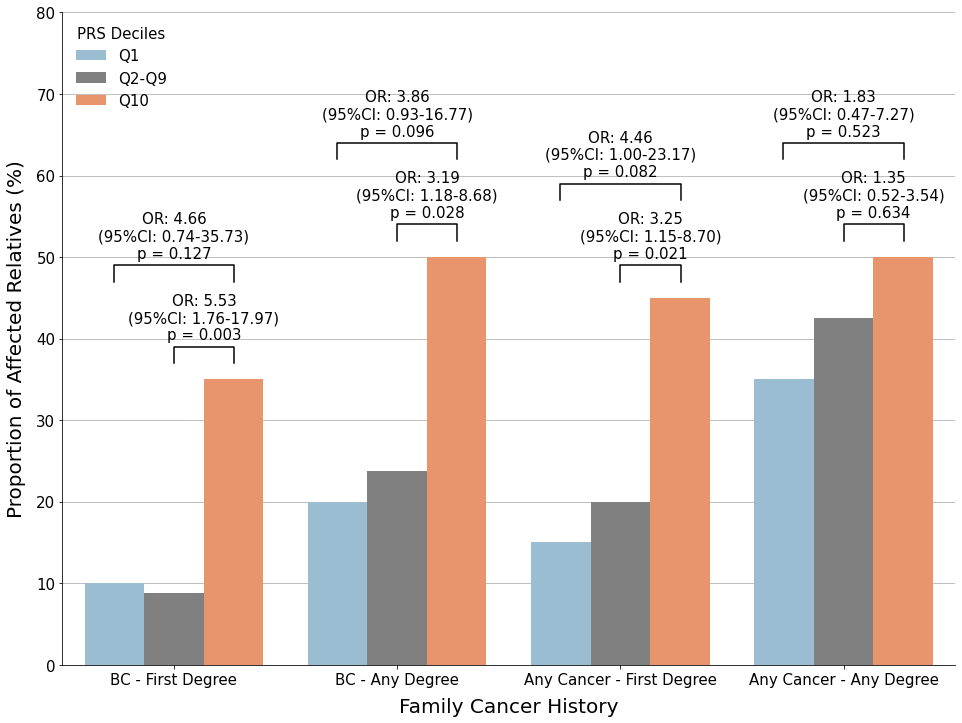

In [220]:
def add_stat_bar(ax,bar_x1,bar_x2,bar_y1,bar_y2,bar_y_top,text="ns",bar_color="black",text_offset=0.5,text_size=medium_font):
    ax.plot([bar_x1, bar_x1, bar_x2, bar_x2], [bar_y1, bar_y_top, bar_y_top, bar_y2], lw=1.5, c=bar_color)
    ax.text((bar_x1+bar_x2)*.5, bar_y_top+text_offset, text, ha='center', va='bottom', color=bar_color,size=text_size)
    return ax

def find_bar_x(string):
    lookup = {
        "BC - First Degree": 0,
        "BC - Any Degree": 1,
        "Any Cancer - First Degree":2,
        "Any Cancer - Any Degree":3
    }
    return lookup[string]

labels_to_plot = [
    "FirstDegreeBC",
    "AnyDegreeBC",
    "FamilyCancer_FirstDegree",
    "FamilyCancer_AnyDegree",
]

from palettable.colorbrewer.diverging import RdYlBu_3

palette = {
    "Q1": RdYlBu_3.mpl_colors[2],
    "Q2-Q9": "gray",
    "Q10": RdYlBu_3.mpl_colors[0]
}

fig,ax = plt.subplots(figsize=(16,12))
ax.grid(axis="y")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim((0,80))

for idx,row in odds_ratio_pair_test_table.iterrows():
    cur_or = f"{row['OR']:.2f}"
    or_lower = f"{row['OR_95CI_lower']:.2f}"
    or_upper = f"{row['OR_95CI_upper']:.2f}"
    cur_pval = f"{row['fisher_pval']:.3f}"
    if row["group_1"] == "Q10":
        init_x = find_bar_x(row["label"])
        if row["group_2"] == "Q1":
            bar_x1 = init_x-0.27
        elif row["group_2"] == "Q2-Q9":
            bar_x1 = init_x
        bar_x2 = init_x+0.27
        
        text = f"OR: {cur_or}\n(95%CI: {or_lower}-{or_upper})\np = {cur_pval}"
        g1_y = row["group_1_case"] / (row["group_1_case"]+row["group_1_control"])
        g2_y = row["group_2_case"] / (row["group_2_case"]+row["group_2_control"])
        bar_y = max(g1_y,g2_y) * 100
        bar_y += 2
        if row["group_2"] == "Q1":
            bar_y += 10
        add_stat_bar(ax,
                     bar_x1=bar_x1,bar_x2=bar_x2,
                     bar_y1=bar_y,bar_y_top=bar_y+2,bar_y2=bar_y,
                     text = text)

            

ax.tick_params(axis='both', which='major', labelsize=medium_font)

prevalence_barplot = sns.barplot(data=odds_ratio_df_plain,x="label",y="percentage",hue="quantile_text",ax=ax,palette=palette,zorder=100)
sns.move_legend(prevalence_barplot,loc="upper left",frameon=False,title="PRS Deciles",fontsize=medium_font,title_fontsize=medium_font)

ax.set_ylabel("Proportion of Affected Relatives (%)",size=large_font,labelpad=10)
ax.set_xlabel("Family Cancer History",size=large_font,labelpad=10)


plt.savefig("figures/fig_6_pre_removal_prs_deciles.png",dpi=300,bbox_layout="tight")
plt.savefig("figures/fig_6_pre_removal_prs_deciles.eps",dpi=300,bbox_layout="tight")





## Panel B (Post-Removal)

In [208]:
odds_ratio_df_no_patho = make_odds_ratio_table(
    clinical_df_filtered[clinical_df_filtered["Patho_Short_Variant_Carrier"]==False],
    prs_to_use_adjusted_std,
    labels_to_plot,
    num_q=10,
    merge_middle=True
)

odds_ratio_df_no_patho = odds_ratio_df_no_patho.replace({
    "FirstDegreeBC":"BC - First Degree",
    "AnyDegreeBC": "BC - Any Degree",
    "FamilyCancer_FirstDegree" :"Any Cancer - First Degree",
    "FamilyCancer_AnyDegree": "Any Cancer - Any Degree"
})

odds_ratio_no_patho_pair_test_table = create_pair_test_df(odds_ratio_df_no_patho)
odds_ratio_no_patho_pair_test_table

,label,group_1,group_2,group_1_case,group_1_control,group_2_case,group_2_control,OR,OR_95CI_lower,OR_95CI_upper,fisher_pval
0,BC - First Degree,Q1,Q2-Q9,0,17,9,124,0.000000,0.0000,3.6549,0.598448
1,BC - First Degree,Q1,Q10,0,17,6,11,0.000000,0.0000,0.6518,0.018404
2,BC - First Degree,Q2-Q9,Q1,9,124,0,17,inf,0.2736,inf,0.598448
3,BC - First Degree,Q2-Q9,Q10,9,124,6,11,0.136200,0.0375,0.4902,0.002328
4,BC - First Degree,Q10,Q1,6,11,0,17,inf,1.5342,inf,0.018404
5,BC - First Degree,Q10,Q2-Q9,6,11,9,124,7.342132,2.0401,26.6624,0.002328
6,BC - Any Degree,Q1,Q2-Q9,1,16,25,108,0.271631,0.0126,1.8104,0.308180
7,BC - Any Degree,Q1,Q10,1,16,9,8,0.060728,0.0024,0.5612,0.006600
8,BC - Any Degree,Q2-Q9,Q1,25,108,1,16,3.681464,0.5524,79.5770,0.308180
9,BC - Any Degree,Q2-Q9,Q10,25,108,9,8,0.208645,0.0693,0.6037,0.003739


<ipython-input-219-0b206cb0c035>:50: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_6_post_removal_prs_deciles.png",dpi=300,bbox_layout="tight")
<ipython-input-219-0b206cb0c035>:51: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fig_6_post_removal_prs_deciles.eps",dpi=300,bbox_layout="tight")


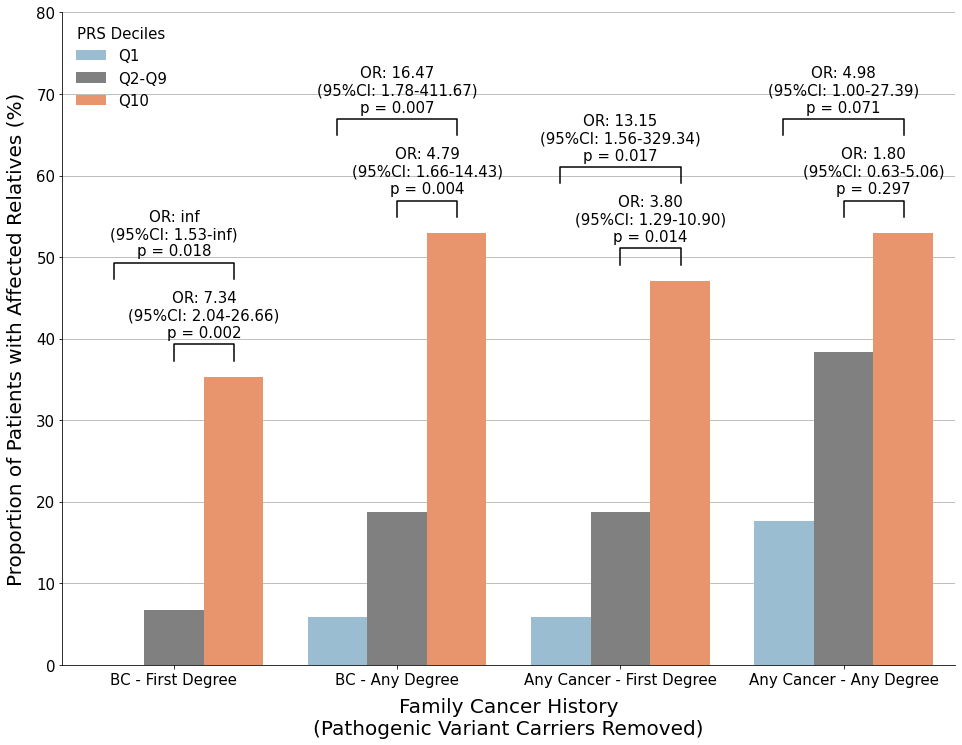

In [219]:
palette = {
    "Q1": RdYlBu_3.mpl_colors[2],
    "Q2-Q9": "gray",
    "Q10": RdYlBu_3.mpl_colors[0]
}

fig,ax = plt.subplots(figsize=(16,12))
ax.grid(axis="y")

ax.set_ylim((0,80))

for idx,row in odds_ratio_no_patho_pair_test_table.iterrows():
    cur_or = f"{row['OR']:.2f}"
    or_lower = f"{row['OR_95CI_lower']:.2f}"
    or_upper = f"{row['OR_95CI_upper']:.2f}"
    cur_pval = f"{row['fisher_pval']:.3f}"
    if row["group_1"] == "Q10":
        init_x = find_bar_x(row["label"])
        if row["group_2"] == "Q1":
            bar_x1 = init_x-0.27
        elif row["group_2"] == "Q2-Q9":
            bar_x1 = init_x
        bar_x2 = init_x+0.27
        
        text = f"OR: {cur_or}\n(95%CI: {or_lower}-{or_upper})\np = {cur_pval}"
        g1_y = row["group_1_case"] / (row["group_1_case"]+row["group_1_control"])
        g2_y = row["group_2_case"] / (row["group_2_case"]+row["group_2_control"])
        bar_y = max(g1_y,g2_y) * 100
        bar_y += 2
        if row["group_2"] == "Q1":
            bar_y += 10
        add_stat_bar(ax,
                     bar_x1=bar_x1,bar_x2=bar_x2,
                     bar_y1=bar_y,bar_y_top=bar_y+2,bar_y2=bar_y,
                     text = text)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=medium_font)

prevalence_barplot = sns.barplot(data=odds_ratio_df_no_patho,x="label",y="percentage",hue="quantile_text",ax=ax,palette=palette,zorder=100)
sns.move_legend(prevalence_barplot,loc="upper left",frameon=False,title="PRS Deciles",fontsize=medium_font,title_fontsize=medium_font)


ax.set_ylabel("Proportion of Patients with Affected Relatives (%)",size=large_font,labelpad=10)
ax.set_xlabel("Family Cancer History\n(Pathogenic Variant Carriers Removed)",size=large_font,labelpad=10)

plt.savefig("figures/fig_6_post_removal_prs_deciles.png",dpi=300,bbox_layout="tight")
plt.savefig("figures/fig_6_post_removal_prs_deciles.eps",dpi=300,bbox_layout="tight")




## Panel C) (Compare AUROCs before/after removal of pathogenic variant carriers)

In [ ]:
labels_to_plot = [
    "FirstDegreeBC",
    "AnyDegreeBC",
    "FamilyCancer_FirstDegree",
    "FamilyCancer_AnyDegree",
]

def get_pred_auc_df(df,pred_col,labels_to_plot):
    auroc_df_rows = []

    for idx,label in enumerate(labels_to_plot):
        notna_df = df[df[label].notna()].copy()
        if truth_labels:
            truth = (notna_df[label] == truth_labels[idx]).astype(int).to_numpy()
        else:
            truth = notna_df[label].astype(int).to_numpy()
        num_case = np.sum(truth)
        num_control = len(notna_df)-num_case
        pred = notna_df[pred_col].to_numpy()
        truth = notna_df[label].astype(int).to_numpy()

        fpr, tpr, thresh = metrics.roc_curve(truth, pred)
        auc = metrics.roc_auc_score(truth, pred)
        _,auc_lower,auc_upper = calc_auc_conf(auc,num_case,num_control)
        auroc_df_rows.append([label,num_case,num_control,len(notna_df),auc,auc_lower,auc_upper])
    
    return pd.DataFrame(
        columns=["label","num_case","num_control","num_total","auc","auc_95CI_lower","auc_95CI_upper"],
        data=auroc_df_rows
    )

auc_df = get_pred_auc_df(clinical_df_filtered,prs_to_use_adjusted_std,labels_to_plot)
auc_df["Group"] = f"All Individuals\n(n={len(clinical_df_filtered)})"
auc_df_no_patho = get_pred_auc_df(clinical_df_filtered[clinical_df_filtered["Patho_Short_Variant_Carrier"]==False],prs_to_use_adjusted_std,labels_to_plot)
auc_df_no_patho["Group"] = f"Pathogenic Variant Carriers Excluded\n(n={len(clinical_df_filtered[clinical_df_filtered['Patho_Short_Variant_Carrier']==False])})"

auc_df_combined = pd.concat([auc_df,auc_df_no_patho],ignore_index=True)
auc_df_combined["auc_err_high"] = auc_df_combined["auc_95CI_upper"] - auc_df_combined["auc"]
auc_df_combined["auc_err_low"] = auc_df_combined["auc"] - auc_df_combined["auc_95CI_lower"]

name_replace_dict = {
    "FirstDegreeBC":"BC occurence in 1st degree relative",
    "AnyDegreeBC": "BC occurence in up to 2nd degree relative",
    "FamilyCancer_FirstDegree" :"Any cancer occurence in 1st degree relative",
    "FamilyCancer_AnyDegree": "Any cancer occurence in up to 2nd degree relative"
}

auc_df_combined = auc_df_combined.replace(name_replace_dict)
auc_df_combined = auc_df_combined.sort_values(by=["label","auc"]).copy()
auc_df_combined["group_plot_order"] = [2,2,0,0,3,3,1,1]
auc_df_combined = auc_df_combined.sort_values(by=["group_plot_order","label","auc"]).copy()
auc_df_combined["group_plot_order_shifted"] = [i//2 - (np.power(-1,i)*0.2) for i in range(len(auc_df_combined["group_plot_order"]))]
auc_df_combined
    


### Bootstrapping


In [210]:
# ## This takes a while to run (10-20 minutes on my machine), uncomment to generate the bootstrapped df

# boot_iter = 10000
# boot_auc_dfs = []

# for i in range(boot_iter):
#     boot_df = clinical_df_filtered.sample(frac=1,replace=True,random_state=i)
#     boot_auc_df = get_pred_auc_df(boot_df,prs_to_use_adjusted_std,labels_to_plot)
#     boot_auc_df["boot_iter"] = i
#     boot_auc_df["group"] = "all_individuals"
#     boot_auc_dfs.append(boot_auc_df)
    
#     boot_df_no_patho = boot_df[boot_df["Patho_Short_Variant_Carrier"]==False]
#     boot_df_no_patho = get_pred_auc_df(boot_df_no_patho,prs_to_use_adjusted_std,labels_to_plot)
#     boot_df_no_patho["boot_iter"] = i
#     boot_df_no_patho["group"] = "no_patho_individuals"
#     boot_auc_dfs.append(boot_df_no_patho)
    
    
# booted_auc_df = pd.concat(boot_auc_dfs,ignore_index=True)


# booted_auc_df.to_csv("data/outputs/bootstrapped_auc_df.tsv",sep="\t",index=False)

In [211]:
booted_auc_df = pd.read_csv("data/outputs/bootstrapped_auc_df.tsv",sep="\t")
booted_auc_df.head()

,label,num_case,num_control,num_total,auc,auc_95CI_lower,auc_95CI_upper,boot_iter,group
0,FirstDegreeBC,25,175,200,0.680457,0.558999,0.801915,0,all_individuals
1,AnyDegreeBC,48,152,200,0.535773,0.441006,0.630540,0,all_individuals
2,FamilyCancer_FirstDegree,44,156,200,0.594697,0.496691,0.692703,0,all_individuals
3,FamilyCancer_AnyDegree,78,122,200,0.513346,0.430992,0.595700,0,all_individuals
4,FirstDegreeBC,18,141,159,0.790386,0.661981,0.918791,0,no_patho_individuals


In [212]:
all_individuals_df = booted_auc_df[booted_auc_df["group"]=="all_individuals"].copy()
no_patho_individuals_df = booted_auc_df[booted_auc_df["group"]=="no_patho_individuals"].copy()

auc_diff_df = all_individuals_df[["label","boot_iter"]].copy()
auc_diffs = no_patho_individuals_df["auc"].to_numpy() - all_individuals_df["auc"].to_numpy()
auc_diff_df["auc_diff"] = auc_diffs
auc_diff_df

,label,boot_iter,auc_diff
0,FirstDegreeBC,0,0.109929
1,AnyDegreeBC,0,0.078224
2,FamilyCancer_FirstDegree,0,0.057068
3,FamilyCancer_AnyDegree,0,0.047255
8,FirstDegreeBC,1,0.068774
...,...,...,...
79987,FamilyCancer_AnyDegree,9998,0.043725
79992,FirstDegreeBC,9999,0.064173
79993,AnyDegreeBC,9999,0.088299
79994,FamilyCancer_FirstDegree,9999,0.032234


In [213]:
pval_df_rows = []
for label in auc_diff_df["label"].unique():
    cur_df = auc_diff_df[auc_diff_df["label"]==label]
    failed = len(cur_df[cur_df["auc_diff"]<0])
    total = len(cur_df)
    # We check the number of times when removing patho resulted in LESS AUC than not removing, thats the p-value
    pval = failed/total
    pval_df_rows.append([label,failed,total,pval])
pval_df = pd.DataFrame(columns=["label","failed_trial","total_trial","pval"],data=pval_df_rows)
pval_df

,label,failed_trial,total_trial,pval
0,FirstDegreeBC,136,10000,0.0136
1,AnyDegreeBC,145,10000,0.0145
2,FamilyCancer_FirstDegree,149,10000,0.0149
3,FamilyCancer_AnyDegree,131,10000,0.0131


In [214]:
booted_auc_df_to_plot = booted_auc_df.copy()
booted_auc_df_to_plot = booted_auc_df_to_plot.replace({
    "FirstDegreeBC": "1st-degree Relative\n(Breast Cancer)",
    "AnyDegreeBC": "Any-degree Relative\n(Breast Cancer)",
    "FamilyCancer_FirstDegree": "1st-degree Relative\n(Any Cancer)",
    "FamilyCancer_AnyDegree": "Any-degree Relative\n(Any Cancer)",
    "all_individuals": "Entire Cohort",
    "no_patho_individuals": "PV Carriers Removed"
})

In [215]:
auc_df_combined

,label,num_case,num_control,num_total,auc,auc_95CI_lower,auc_95CI_upper,Group,auc_err_high,auc_err_low,group_plot_order,group_plot_order_shifted
3,Any cancer occurence in up to 2nd degree relative,86,114,200,0.546512,0.465578,0.627445,All Individuals\n(n=200),0.080933,0.080933,0,-0.2
7,Any cancer occurence in up to 2nd degree relative,66,100,166,0.591061,0.501793,0.680329,Pathogenic Variant Carriers Excluded\n(n=166),0.089268,0.089268,0,0.2
1,BC occurence in up to 2nd degree relative,53,147,200,0.604800,0.513487,0.696114,All Individuals\n(n=200),0.091314,0.091314,1,0.8
5,BC occurence in up to 2nd degree relative,37,129,166,0.671066,0.566699,0.775434,Pathogenic Variant Carriers Excluded\n(n=166),0.104367,0.104367,1,1.2
2,Any cancer occurence in 1st degree relative,45,155,200,0.589534,0.492314,0.686754,All Individuals\n(n=200),0.097220,0.097220,2,1.8
6,Any cancer occurence in 1st degree relative,36,130,166,0.650427,0.543813,0.757042,Pathogenic Variant Carriers Excluded\n(n=166),0.106615,0.106615,2,2.2
0,BC occurence in 1st degree relative,25,175,200,0.662629,0.540168,0.785089,All Individuals\n(n=200),0.122461,0.122461,3,2.8
4,BC occurence in 1st degree relative,18,148,166,0.772523,0.641044,0.904001,Pathogenic Variant Carriers Excluded\n(n=166),0.131478,0.131478,3,3.2


In [216]:
patho_individual_og_df = auc_df_combined[auc_df_combined["Group"]=="Pathogenic Variant Carriers Excluded\n(n=166)"].copy()
all_individual_og_df = auc_df_combined[auc_df_combined["Group"]=="All Individuals\n(n=200)"].copy()

auc_diff_og_df = all_individual_og_df[["label"]].copy()
all_indi_temp = all_individual_og_df[["num_case","num_control","num_total","auc"]].copy()
all_indi_temp.columns = [f"{col}_entire_cohort" for col in all_indi_temp.columns]
auc_diff_og_df = pd.concat([auc_diff_og_df,all_indi_temp],axis=1,ignore_index=False).reset_index(drop=True)


patho_temp = patho_individual_og_df[["num_case","num_control","num_total","auc"]].copy()
patho_temp_columns = [f"{col}_non_PV_carriers_only" for col in patho_temp.columns]
patho_temp.columns = patho_temp_columns

auc_diff_og_df[patho_temp_columns] = patho_temp[patho_temp_columns].to_numpy()

auc_diff_og_df["auc_diff"] = auc_diff_og_df["auc_non_PV_carriers_only"].to_numpy() - auc_diff_og_df["auc_entire_cohort"].to_numpy()
auc_diff_og_df["auc_diff_relative"] = auc_diff_og_df["auc_diff"] / auc_diff_og_df["auc_entire_cohort"]
auc_diff_og_df


,label,num_case_entire_cohort,num_control_entire_cohort,num_total_entire_cohort,auc_entire_cohort,num_case_non_PV_carriers_only,num_control_non_PV_carriers_only,num_total_non_PV_carriers_only,auc_non_PV_carriers_only,auc_diff,auc_diff_relative
0,Any cancer occurence in up to 2nd degree relative,86,114,200,0.546512,66.0,100.0,166.0,0.591061,0.044549,0.081515
1,BC occurence in up to 2nd degree relative,53,147,200,0.604800,37.0,129.0,166.0,0.671066,0.066266,0.109567
2,Any cancer occurence in 1st degree relative,45,155,200,0.589534,36.0,130.0,166.0,0.650427,0.060893,0.103291
3,BC occurence in 1st degree relative,25,175,200,0.662629,18.0,148.0,166.0,0.772523,0.109894,0.165845


In [217]:
auc_diff_og_df.to_csv("data/outputs/prs_auc_diff_when_PV_removed.tsv",index=False,sep="\t")

### Plotting

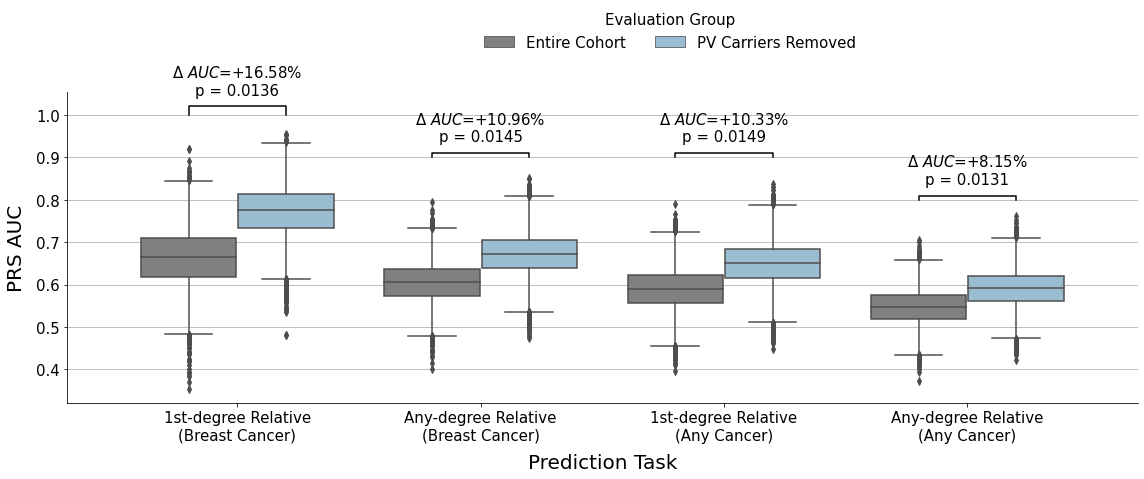

In [232]:
fig,ax = plt.subplots(figsize=(16,7))

hue_colors = {
    "Entire Cohort":"gray",
    "PV Carriers Removed":RdYlBu_3.mpl_colors[2]
}

sns.boxplot(data=booted_auc_df_to_plot,x="label",y="auc",hue="group",ax=ax,palette=hue_colors)

bootstrap_pval_first_bc = pval_df[pval_df["label"]=="FirstDegreeBC"]["pval"].item()
bootstrap_pval_any_bc = pval_df[pval_df["label"]=="AnyDegreeBC"]["pval"].item()
bootstrap_pval_first_cancer = pval_df[pval_df["label"]=="FamilyCancer_FirstDegree"]["pval"].item()
bootstrap_pval_any_cancer = pval_df[pval_df["label"]=="FamilyCancer_AnyDegree"]["pval"].item()

auc_diff_first_bc = auc_diff_og_df[auc_diff_og_df["label"]=="BC occurence in 1st degree relative"]["auc_diff_relative"].item()*100
auc_diff_any_bc = auc_diff_og_df[auc_diff_og_df["label"]=="BC occurence in up to 2nd degree relative"]["auc_diff_relative"].item()*100
auc_diff_first_cancer = auc_diff_og_df[auc_diff_og_df["label"]=="Any cancer occurence in 1st degree relative"]["auc_diff_relative"].item()*100
auc_diff_any_cancer = auc_diff_og_df[auc_diff_og_df["label"]=="Any cancer occurence in up to 2nd degree relative"]["auc_diff_relative"].item()*100

first_bc_text = r"${\Delta}\ AUC$" + f"={auc_diff_first_bc:+.2f}%"+ f"\np = {bootstrap_pval_first_bc}"
any_bc_text = r"${\Delta}\ AUC$" + f"={auc_diff_any_bc:+.2f}%"+ f"\np = {bootstrap_pval_any_bc}"
first_cancer_text = r"${\Delta}\ AUC$" + f"={auc_diff_first_cancer:+.2f}%"+ f"\np = {bootstrap_pval_first_cancer}"
any_cancer_text = r"${\Delta}\ AUC$" + f"={auc_diff_any_cancer:+.2f}%"+ f"\np = {bootstrap_pval_any_cancer}"

add_stat_bar(ax,bar_x1=-0.2,bar_x2=0.2,bar_y1=1,bar_y2=1,bar_y_top=1.02,text = first_bc_text,text_offset=0.02)
add_stat_bar(ax,bar_x1=1-0.2,bar_x2=1+0.2,bar_y1=0.9,bar_y2=0.9,bar_y_top=0.91,text = any_bc_text,text_offset=0.02)
add_stat_bar(ax,bar_x1=2-0.2,bar_x2=2+0.2,bar_y1=0.9,bar_y2=0.9,bar_y_top=0.91,text = first_cancer_text,text_offset=0.02)
add_stat_bar(ax,bar_x1=3-0.2,bar_x2=3+0.2,bar_y1=0.8,bar_y2=0.8,bar_y_top=0.81,text = any_cancer_text,text_offset=0.02)

ax.set_axisbelow(True)
ax.grid(axis="y")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=medium_font)
ax.set_ylabel("PRS AUC",size=large_font,labelpad=10)
ax.set_xlabel("Prediction Task",size=large_font,labelpad=10)

sns.move_legend(
    ax,loc="upper right",frameon=False,fontsize=medium_font,title_fontsize=medium_font,
    title="Evaluation Group",bbox_to_anchor=(0.75,1.3),ncol=2
)

plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.savefig("figures/fig_6_pv_removal_auc_comparison.png",dpi=300)#,bbox_layout="tight")
plt.savefig("figures/fig_6_pv_removal_auc_comparison.eps",dpi=300)#,bbox_layout="tight")




# Supplementary Materials

## S1: Clinical Data Table 

In [65]:
clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"]==True),
    "BC_Group"
] = "Breast Cancer\nFirst-Degree"
clinical_df_filtered.loc[
    (clinical_df_filtered["SecondDegreeBC"]==True)&
    (clinical_df_filtered["FirstDegreeBC"]==False),
    "BC_Group"
] = "Breast Cancer\nSecond-Degree Only"

clinical_df_filtered.loc[
    (clinical_df_filtered["AnyDegreeBC"]==False)&
    (clinical_df_filtered["FamilyCancer_AnyDegree"]==True),
    "BC_Group"
] = "Other Cancer\nAny-Degree"

clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"]==False)&
    (clinical_df_filtered["SecondDegreeBC"]==False)&
    (clinical_df_filtered["FamilyCancer_FirstDegree"]==False)&
    (clinical_df_filtered["FamilyCancer_SecondDegree"]==False),
    "BC_Group"
] = "No Reported Cancer in Family"

clinical_df_filtered["BC_Group"].value_counts()

No Reported Cancer in Family         114
Other Cancer\nAny-Degree              33
Breast Cancer\nSecond-Degree Only     28
Breast Cancer\nFirst-Degree           25
Name: BC_Group, dtype: int64

In [66]:
clinical_df_filtered.loc[
    clinical_df_filtered["Breast_Cancer_Subtype_ki67_unused"].notna(), "TripleNegative"
] = 0

clinical_df_filtered.loc[
    clinical_df_filtered["Breast_Cancer_Subtype_ki67_unused"] == "Triple_Negative", "TripleNegative"
] = 1

clinical_df_filtered["TripleNegative"].value_counts()

pd.get_dummies(clinical_df_filtered,columns=["CancerStage_M"],dummy_na=True)

,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,ER+,PR+,HER2+,Breast_Cancer_Subtype_ki67_unused,...,fam_patho_group,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual_Decile,population_adjusted_prs_std,population_adjusted_prs_raw,BC_Group,TripleNegative,CancerStage_M_0-M0,CancerStage_M_1-M1,CancerStage_M_5-Mx,CancerStage_M_nan
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,True,True,False,luminal_A,...,"No First Degree BC, PV Carrier",3,-0.777759,-1.165669e-06,No Reported Cancer in Family,0.0,1,0,0,0
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,True,False,False,luminal_A,...,"First Degree BC, No PV",7,0.442861,6.637397e-07,Breast Cancer\nFirst-Degree,0.0,1,0,0,0
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,False,False,False,Triple_Negative,...,"No First Degree BC, PV Carrier",2,-1.190310,-1.783982e-06,Breast Cancer\nSecond-Degree Only,1.0,1,0,0,0
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,True,True,False,luminal_A,...,"No First Degree BC, No PV",9,1.092739,1.637747e-06,No Reported Cancer in Family,0.0,1,0,0,0
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,False,False,True,HER2_Enriched,...,"No First Degree BC, No PV",5,-0.137074,-2.054409e-07,No Reported Cancer in Family,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,BC_P_231,51.0,12- Other,2-Grade 2,1-T1c,0-No,True,True,False,luminal_A,...,"No First Degree BC, No PV",6,0.180187,2.700567e-07,No Reported Cancer in Family,0.0,1,0,0,0
211,BC_P_232,61.0,1-Ductal carcinoma in situ,2-Grade 2,1-T1c,0-No,True,True,False,luminal_A,...,"No First Degree BC, No PV",7,0.395077,5.921236e-07,No Reported Cancer in Family,0.0,1,0,0,0
212,BC_P_233,49.0,3-Invasive ductal carcinoma,3-Grade 3,1-T1c,1-N1,True,True,False,luminal_A,...,"No First Degree BC, No PV",4,-0.353830,-5.303044e-07,No Reported Cancer in Family,0.0,1,0,0,0
215,BC_P_236,64.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,True,True,NaN,luminal_A,...,"No First Degree BC, No PV",3,-0.875538,-1.312216e-06,Other Cancer\nAny-Degree,0.0,1,0,0,0


In [67]:
clinical_df_filtered_info = clinical_df_filtered.groupby("BC_Group").agg({
    "Age": ["count","mean","std"],
    "ER+": ["count","sum","mean"],
    "PR+": ["count","sum","mean"],
    "HER2+": ["count","sum","mean"],
    "TripleNegative":["count","sum","mean"],
}).T

clinical_df_filtered_info


BC_Group              Breast Cancer\nFirst-Degree  \
Age            count                    25.000000   
               mean                     48.080000   
               std                       9.586970   
ER+            count                    15.000000   
               sum                      12.000000   
               mean                      0.800000   
PR+            count                    15.000000   
               sum                      11.000000   
               mean                      0.733333   
HER2+          count                    15.000000   
               sum                       3.000000   
               mean                      0.200000   
TripleNegative count                    15.000000   
               sum                       1.000000   
               mean                      0.066667   

BC_Group              Breast Cancer\nSecond-Degree Only  \
Age            count                          28.000000   
               mean                           44.678571   
               std                             9.790599   
ER+            count                          21.000000   
               sum                            15.000000   
               mean                            0.714286   
PR+            count                          21.000000   
               sum                            13.000000   
               mean                            0.619048   
HER2+          count                          21.000000   
               sum                             4.000000   
               mean                            0.190476   
TripleNegative count                          21.000000   
               sum                             6.000000   
               mean                            0.285714   

BC_Group              No Reported Cancer in Family  Other Cancer\nAny-Degree  
Age            count                    114.000000                 33.000000  
               mean                      48.236842                 48.969697  
               std                       10.520358                  8.790922  
ER+            count                     83.000000                 26.000000  
               sum                       66.000000                 22.000000  
               mean                       0.795181                  0.846154  
PR+            count                     83.000000                 26.000000  
               sum                       62.000000                 19.000000  
               mean                       0.746988                  0.730769  
HER2+          count                     78.000000                 23.000000  
               sum                       17.000000                  8.000000  
               mean                       0.217949                  0.347826  
TripleNegative count                     83.000000                 26.000000  
               sum                        9.000000                  2.000000  
               mean                       0.108434                  0.076923

In [68]:
t_stage_ct = pd.crosstab(clinical_df_filtered["BC_Group"],clinical_df_filtered["CancerStage_T_Ordinal"]).T
t_stage_ct.index = [f"T_stage_{stage}" for stage in t_stage_ct.index]

n_stage_ct = pd.crosstab(clinical_df_filtered["BC_Group"],clinical_df_filtered["CancerStage_N_Ordinal"]).T
n_stage_ct.index = [f"N_stage_{stage}" for stage in n_stage_ct.index]

m_stage_ct = pd.crosstab(clinical_df_filtered["BC_Group"],clinical_df_filtered["CancerStage_M_Ordinal"]).T
m_stage_ct.index = [f"M_stage_{stage}" for stage in m_stage_ct.index]

clinical_df_filtered_info = pd.concat([clinical_df_filtered_info,t_stage_ct,n_stage_ct,m_stage_ct])
clinical_df_filtered_info

BC_Group,Breast Cancer\nFirst-Degree,Breast Cancer\nSecond-Degree Only,No Reported Cancer in Family,Other Cancer\nAny-Degree
"(Age, count)",25.000000,28.000000,114.000000,33.000000
"(Age, mean)",48.080000,44.678571,48.236842,48.969697
"(Age, std)",9.586970,9.790599,10.520358,8.790922
"(ER+, count)",15.000000,21.000000,83.000000,26.000000
"(ER+, sum)",12.000000,15.000000,66.000000,22.000000
"(ER+, mean)",0.800000,0.714286,0.795181,0.846154
"(PR+, count)",15.000000,21.000000,83.000000,26.000000
"(PR+, sum)",11.000000,13.000000,62.000000,19.000000
"(PR+, mean)",0.733333,0.619048,0.746988,0.730769
"(HER2+, count)",15.000000,21.000000,78.000000,23.000000


In [70]:
clinical_df_filtered_info.to_csv(
    "data/supplementary_tables/S1_demographics_by_family_history_raw.tsv",
    sep="\t"
)


## S2: Imputation Performance by INFO Table (See PlotExome Notebook)

## S3: Imputation Performance by MAF Table  (See PlotExome Notebook)

## S4: PRS Performance Table

In [71]:
prs_web_fam_df_merged_supp_table = prs_web_fam_df_merged.copy()
column_names_pretty_order = [
    "prs_name","# SNPS","Method","DB",
    "prs_first_fam_auroc_prs_only","prs_resid_first_fam_auroc",
    "prs_any_fam_auroc_prs_only","prs_resid_any_fam_auroc",
    "prs_adjusted_delta_first_fam","prs_adjusted_delta_any_fam"
]

prs_web_fam_df_merged_supp_table = prs_web_fam_df_merged_supp_table[column_names_pretty_order].copy()

column_names_pretty = {
    "prs_name": "PRS ID",
    "# SNPS": "Number of SNPs in PRS",
    "Method": "PRS Derivation Method",
    "DB": "AUC_population Validation Database",
    "prs_first_fam_auroc_prs_only": 'PRS_raw AUC_fam',
    "prs_resid_first_fam_auroc": 'PRS_adjusted AUC_fam',
    "prs_any_fam_auroc_prs_only": "PRS_raw AUC_fam-any",
    "prs_resid_any_fam_auroc": "PRS_adjusted AUC_fam-any",
    "prs_adjusted_delta_first_fam":"Change in AUC_fam after adjusting for population",
    "prs_adjusted_delta_any_fam": "Change in AUC_fam-any after adjusting for population"
}


prs_web_fam_df_merged_supp_table = prs_web_fam_df_merged_supp_table.rename(columns=column_names_pretty)
prs_web_fam_df_merged_supp_table

,PRS ID,Number of SNPs in PRS,PRS Derivation Method,AUC_population Validation Database,PRS_raw AUC_fam,PRS_adjusted AUC_fam,PRS_raw AUC_fam-any,PRS_adjusted AUC_fam-any,Change in AUC_fam after adjusting for population,Change in AUC_fam-any after adjusting for population
0,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,118388,Lassosum,MGI,0.649371,0.662629,0.596072,0.604800,1.325714e-02,0.008728
1,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,286144,Lassosum,UKB,0.655771,0.661943,0.587088,0.586831,6.171429e-03,-0.000257
2,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,6977,Lassosum,MGI,0.666171,0.656000,0.581954,0.579772,-1.017143e-02,-0.002182
3,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,1116546,PRS-CS,UKB,0.625029,0.641829,0.551405,0.563214,1.680000e-02,0.011808
4,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,79,P&T,UKB,0.573486,0.572571,0.556283,0.553074,-9.142857e-04,-0.003209
5,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,1682,P&T,UKB,0.566857,0.579657,0.551149,0.551277,1.280000e-02,0.000128
6,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,105,GWAS Catalog ($p<5\times10^{-5}$),UKB,0.558400,0.549943,0.562315,0.551020,-8.457143e-03,-0.011295
7,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,3038,P&T,MGI,0.593029,0.601829,0.551983,0.550635,8.800000e-03,-0.001348
8,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,1119140,PRS-CS,MGI,0.569600,0.575771,0.540752,0.545630,6.171429e-03,0.004877
9,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PR...,1120410,PRS-CS,UKB,0.591086,0.603200,0.541843,0.544859,1.211429e-02,0.003016


In [72]:
prs_web_fam_df_merged_supp_table.to_csv(
    "data/supplementary_tables/S4_prs_performance.tsv",
    sep="\t",index=False
)




## S5: PRS Performance before and after removing PV carriers

In [73]:
pval_df["label"] = pval_df["label"].replace({
    "FirstDegreeBC":"BC occurence in 1st degree relative",
    "AnyDegreeBC": "Any cancer occurence in 1st degree relative",
    "FamilyCancer_FirstDegree":"Any cancer occurence in 1st degree relative",
    "FamilyCancer_AnyDegree": "Any cancer occurence in up to 2nd degree relative"
})

auc_diff_og_df_merged = auc_diff_og_df.merge(pval_df,on="label")
auc_diff_og_df_merged

,label,num_case_entire_cohort,num_control_entire_cohort,num_total_entire_cohort,auc_entire_cohort,num_case_non_PV_carriers_only,num_control_non_PV_carriers_only,num_total_non_PV_carriers_only,auc_non_PV_carriers_only,auc_diff,auc_diff_relative,failed_trial,total_trial,pval
0,Any cancer occurence in up to 2nd degree relative,86,114,200,0.546512,66.0,100.0,166.0,0.591061,0.044549,0.081515,131,10000,0.0131
1,Any cancer occurence in 1st degree relative,45,155,200,0.589534,36.0,130.0,166.0,0.650427,0.060893,0.103291,145,10000,0.0145
2,Any cancer occurence in 1st degree relative,45,155,200,0.589534,36.0,130.0,166.0,0.650427,0.060893,0.103291,149,10000,0.0149
3,BC occurence in 1st degree relative,25,175,200,0.662629,18.0,148.0,166.0,0.772523,0.109894,0.165845,136,10000,0.0136


In [74]:
auc_diff_og_df_merged.to_csv(
    "data/supplementary_tables/S5_effects_of_removing_PV_carriers.tsv",
    sep="\t",index=False
)